In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import time as ttm

import miura_method as mm
import response_factor as rf

# 後退差分での離散化（空間、時間）分割数による熱流の変化検討

In [2]:
d = {
    'walls': [
        {
            'name': '1F床（木造）',
            'R': [0.15, 0.022 / 0.16, 0.15 / 0.05, 0.04],
            'C': [0.0, 720 * 0.022 * 1000, 13 * 0.15 * 1000, 0.0]
        },
        {
            'name': '外壁（木造）',
            'R': [0.11, 0.012 / 0.22, 0.1 / 0.05, 1 / 11.11, 0.009 / 0.16, 0.03 / 1.5, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 13 * 0.1 * 1000, 0.0, 720 * 0.009 * 1000, 1600 * 0.03 * 1000, 0.0]
        },
        {
            'name': '2階天井（木造）',
            'R': [0.09, 0.012 / 0.22, 0.2 / 0.05, 1 / 11.11, 0.012 / 0.16, 0.001 / 55, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 8 * 0.2 * 1000, 0.0, 720 * 0.012 * 1000, 3600 * 0.001 * 1000, 0.0]
        },
        {
            'name': '間仕切',
            'R': [0.11, 0.012 / 0.22, 1 / 11.11, 0.012 / 0.22, 0.11],
            'C': [0.0, 830 * 0.012 * 1000, 0.0, 830 * 0.012 * 1000, 0.0]
        },
        {
            'name': '屋根（RC）',
            'R': [0.09, 0.012 / 0.22, 1 / 11.11, 0.05 / 0.028, 0.135 / 1.6, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 0.0, 40 * 0.05 * 1000, 0.135 * 2000 * 1000, 0.0]
        },
        {
            'name': '外壁（RC）',
            'R': [0.11, 0.012 / 0.22, 1 / 11.11, 0.05 / 0.028, 0.15 / 1.6, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 0.0, 0.05 * 40 * 1000, 0.15 * 2000 * 1000,  0.0]
        },
        {
            'name': '床（RC）',
            'R': [0.15, 0.022 / 0.16, 1 / 11.11, 0.13 / 1.6, 0.05 / 0.028, 0.04],
            'C': [0.0, 720 * 0.022 * 1000, 0.0, 2000 * 0.13 * 1000, 40 * 0.05 * 1000, 0.0]
        },
        {
            'name': '天井（木造）UA=0.2',
            'R': [0.09, 0.01 / 0.22, 0.644 / 0.05, 0.04],
            'C': [0.0, 830 * 0.01 * 1000, 8 * 0.01 * 1000, 0.0]
        }
    ]
}


In [3]:
# 留数定理による根の数の最大値
n_alpha_max = 200

In [4]:
def calc_u_L_and_u_R(virtual_R: np.ndarray, virtual_C: np.ndarray, delta_t: float) -> (np.ndarray, np.ndarray):

    u_L = delta_t / (virtual_C * virtual_R[:len(virtual_C)])
    u_R = delta_t / (virtual_C * virtual_R[1:])

    return (u_R, u_L)

In [5]:
def make_inv_U(u_R: np.ndarray, u_L: np.ndarray, n_layers: int) -> np.ndarray:

    # 行列[U]の作成
    matrix_U = np.zeros((n_layers + 1, n_layers + 1))
    for i in range(n_layers + 1):
        matrix_U[i, i] = 1.0 + u_L[i] + u_R[i]
        if i > 0:
            matrix_U[i, i - 1] = - u_L[i]
            matrix_U[i - 1, i] = - u_R[i - 1]
    
    # 逆行列の計算
    return np.linalg.inv(matrix_U)

In [6]:
def calc_q_a_flow(inv_U: np.ndarray, R0: float, u_L0: float, n_layers: int, n_max: int) -> np.ndarray:

    # 初期温度
    theta_0 = np.zeros(n_layers + 1)
    # 境界温度（吸熱応答用）
    theta_boundary_a = np.zeros(n_layers + 1)
    theta_boundary_a[0] = u_L0 * 1.0
    # 熱流
    q_a = np.zeros(n_max)

    for i in range(n_max):
        theta_0 = np.dot(inv_U, (theta_0 + theta_boundary_a))
        q_a[i] = (1.0 - theta_0[0]) / R0
    
    return q_a

In [7]:
def calc_q_t_flow(inv_U: np.ndarray, R0: float, u_Rmax: float, n_layers: int, n_max: int) -> np.ndarray:

    # 初期温度
    theta_0 = np.zeros(n_layers + 1)
    # 境界温度（貫流応答用）
    theta_boundary_t = np.zeros(n_layers + 1)
    theta_boundary_t[len(theta_boundary_t) - 1] = u_Rmax * 1.0
    # 熱流
    q_t = np.zeros(n_max)

    for i in range(n_max):
        theta_0 = np.dot(inv_U, (theta_0 + theta_boundary_t))
        q_t[i] = (theta_0[0] - 0.0) / R0
    
    return q_t

In [8]:
def calc_surface_heat_flow_rf(R: np.ndarray, C: np.ndarray, delta_t: float, n_max: int, n_alpha_max: int) \
    -> (np.ndarray, np.ndarray, float, float, np.ndarray, np.ndarray, np.ndarray):

    # 留数定理での単位応答の計算
    # 根の計算
    a0, aa, at, alpha = rf.calc_alpha_matsuo_method(rs=R, cs=C, i_max=n_alpha_max)

    # 単位応答の計算
    phi_a, phi_t = rf.calc_step_respose_factor(aa=aa, at=at, alpha=alpha, a0=a0, n_max=n_max, delta_t=delta_t)

    # 応答係数の初項、指数項別応答係数の計算
    rft_a0, rft_t0, rft_a1, rft_t1, Row = rf.calc_triangle_response_factor(aa=aa, at=at, alpha=alpha, a0=a0, delta_t=delta_t)

    return phi_a, phi_t, rft_a0, rft_t0, rft_a1, rft_t1, Row, alpha

In [9]:
# RMSEの計算関数
def RMSE(rf: np.ndarray, fdm: np.ndarray):
    return np.sqrt(mean_squared_error(rf, fdm))

In [10]:
def calc_surface_heat_flow_trif(
        delta_t: float,
        n_layers: int,
        R0: float,
        u_L: np.ndarray,
        u_R: np.ndarray,
        inv_U: np.ndarray,
        alpha: np.ndarray,
        rft_t0: float,
        rft_a0: float,
        rft_a1: np.ndarray,
        rft_t1: np.ndarray,
        Row: np.ndarray) \
     -> (float, float):

    # 境界条件
    time_angle = np.arange(start=0.0, stop=365+delta_t/3600/24, step=delta_t/3600/24, dtype=float)
    theta_eo_array = np.sin(time_angle * (2 * math.pi))
    theta_ei_array = np.cos(time_angle * (2 * math.pi))

    # 後退差分法での計算
    # 初期温度
    theta_0 = np.zeros(n_layers + 1)
    # 境界温度（貫流応答用）
    theta_boundary = np.zeros((n_layers + 1, len(theta_eo_array)))
    theta_boundary[0,:] = u_L[0] * theta_ei_array
    theta_boundary[len(theta_boundary) - 1,:] = u_R[len(u_R) - 1] * theta_eo_array
    # 熱流
    q_fdm = np.zeros_like(theta_eo_array)
    # 表面温度
    theta_surf = np.zeros_like(theta_eo_array)

    start = ttm.time()
    for i, time in enumerate(time_angle):
        theta_0 = np.dot(inv_U, (theta_0 + theta_boundary[:, i]))
        q_fdm[i] = (theta_0[0] - theta_ei_array[i]) / R0
        theta_surf[i] = theta_0[0]
    elapsed_time = ttm.time() - start

    # 応答係数法での計算
    q_dsh_srf_t = np.zeros_like(alpha)
    q_dsh_srf_a = np.zeros_like(alpha)

    # 熱流
    q_rf = np.zeros_like(theta_eo_array)
    theta_rf_surf = np.zeros_like(theta_eo_array)

    for i, time in enumerate(time_angle):
        q_rf[i] = rft_t0 * theta_eo_array[i] + np.sum(q_dsh_srf_t) \
                    - (rft_a0 * theta_ei_array[i] + np.sum(q_dsh_srf_a))
        q_dsh_srf_a = theta_ei_array[i] * rft_a1 + Row * q_dsh_srf_a
        q_dsh_srf_t = theta_eo_array[i] * rft_t1 + Row * q_dsh_srf_t
        theta_rf_surf[i] = q_rf[i] * R0 + theta_ei_array[i]

    # 1日のステップ数
    n_step = int(24 * 3600 / delta_t)
    q_fdm_lastday = q_fdm[-n_step:]
    q_rf_lastday = q_rf[-n_step:]

    # RMSEの計算
    rmse_trif = RMSE(rf=q_rf_lastday, fdm=q_fdm_lastday)

    # MAEの計算
    mae_trif = mean_absolute_error(q_rf_lastday, q_fdm_lastday)

    return rmse_trif, mae_trif, q_fdm, q_rf, elapsed_time

In [11]:
def calc_surface_heat_flow(R: np.ndarray, C: np.ndarray, n_layers: int, delta_t: float):

    # 差分計算する層間の熱抵抗と格子点熱容量の計算
    virtual_R, virtual_C = mm.miura_method(R=R, C=C, n_layers=n_layers)

    u_R, u_L = calc_u_L_and_u_R(virtual_R=virtual_R, virtual_C=virtual_C, delta_t=delta_t)

    # 係数行列[U]の逆行列の計算
    inv_U = make_inv_U(u_R=u_R, u_L=u_L, n_layers=n_layers)

    # 単位応答を求める項数の計算
    n_max = int(100 / (delta_t / 3600))

    # 境界温度（吸熱応答用）
    q_a = calc_q_a_flow(inv_U=inv_U, R0=R[0], u_L0=u_L[0], n_layers=n_layers, n_max=n_max)

    # 境界温度（貫流応答用）
    q_t = calc_q_t_flow(inv_U=inv_U, R0=R[0], u_Rmax=u_R[len(u_R) - 1], n_layers=n_layers, n_max=n_max)

    # 留数定理による応答係数の計算
    phi_a, phi_t, rft_a0, rft_t0, rft_a1, rft_t1, Row, alpha = calc_surface_heat_flow_rf(R=R, C=C, delta_t=delta_t, n_max=n_max, n_alpha_max=n_alpha_max)

    # 単位応答に対するMAE、RMSEの計算
    # MAEの計算
    mae_a = mean_absolute_error(phi_a, q_a)
    n_24 = int(24 * 3600 / delta_t)
    # 24時間分のRMSEを計算
    mae_a_24 = mean_absolute_error(phi_a[:n_24], q_a[:n_24])

    mae_t = mean_absolute_error(phi_t, q_t)
    mae_t_24 = mean_absolute_error(phi_t[:n_24], q_t[:n_24])

    # RMSEの計算
    rmse_a = RMSE(rf=phi_a, fdm=q_a)
    # 24時間分のRMSEを計算
    rmse_a_24 = RMSE(rf=phi_a[:n_24], fdm=q_a[:n_24])

    rmse_t = RMSE(rf=phi_t, fdm=q_t)
    rmse_t_24 = RMSE(rf=phi_t[:n_24], fdm=q_t[:n_24])

    # 三角関数波励振の熱流でのRMSE、MAEの計算
    rmse_trif, mae_trif, q_fdm, q_rf, elapsed_time = calc_surface_heat_flow_trif(
        delta_t=delta_t,
        n_layers=n_layers,
        R0=R[0],
        u_L=u_L,
        u_R=u_R,
        inv_U=inv_U,
        alpha=alpha,
        rft_t0=rft_t0,
        rft_a0=rft_a0,
        rft_a1=rft_a1,
        rft_t1=rft_t1,
        Row=Row)

    return rmse_a, rmse_a_24, rmse_t, rmse_t_24, mae_a, mae_a_24, mae_t, mae_t_24, rmse_trif, mae_trif, q_a, q_t, phi_a, phi_t, q_fdm, q_rf, elapsed_time

In [12]:
# 検討するパラメータ
delta_t_all = np.array([60.0, 300.0, 600.0, 900.0, 1800.0, 3600.0])
n_layers_all = np.array([2, 3, 5, 10])
d_index_all = np.arange(stop=len(d['walls']))

# 全組み合わせの配列を作成
delta_t_array, n_layers_array, d_index_array \
    = np.meshgrid(delta_t_all, n_layers_all, d_index_all)

delta_t_array = delta_t_array.flatten()
n_layers_array = n_layers_array.flatten()
d_index_array = d_index_array.flatten()

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 0
9 1
10 2
11 3
12 4
13 5
14 6
15 7
16 0
17 1
18 2
19 3
20 4


C:\Users\satoh\AppData\Local\Temp\ipykernel_25288\327471968.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, squeeze=False)


21 5
22 6
23 7
24 0
25 1
26 2
27 3
28 4
29 5
30 6
31 7
32 0
33 1
34 2
35 3
36 4
37 5
38 6
39 7
40 0
41 1
42 2
43 3
44 4
45 5
46 6
47 7
48 0
49 1
50 2
51 3
52 4
53 5
54 6
55 7
56 0
57 1
58 2
59 3
60 4
61 5
62 6
63 7
64 0
65 1
66 2
67 3
68 4
69 5
70 6
71 7
72 0
73 1
74 2
75 3
76 4
77 5
78 6
79 7
80 0
81 1
82 2
83 3
84 4
85 5
86 6
87 7
88 0
89 1
90 2
91 3
92 4
93 5
94 6
95 7
96 0
97 1
98 2
99 3
100 4
101 5
102 6
103 7
104 0
105 1
106 2
107 3
108 4
109 5
110 6
111 7
112 0
113 1
114 2
115 3
116 4
117 5
118 6
119 7
120 0
121 1
122 2
123 3
124 4
125 5
126 6
127 7
128 0
129 1
130 2
131 3
132 4
133 5
134 6
135 7
136 0
137 1
138 2
139 3
140 4
141 5
142 6
143 7
144 0
145 1
146 2
147 3
148 4
149 5
150 6
151 7
152 0
153 1
154 2
155 3
156 4
157 5
158 6
159 7
160 0
161 1
162 2
163 3
164 4
165 5
166 6
167 7
168 0
169 1
170 2
171 3
172 4
173 5
174 6
175 7
176 0
177 1
178 2
179 3
180 4
181 5
182 6
183 7
184 0
185 1
186 2
187 3
188 4
189 5
190 6
191 7


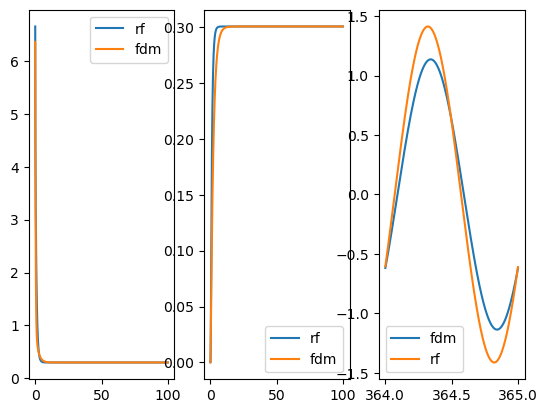

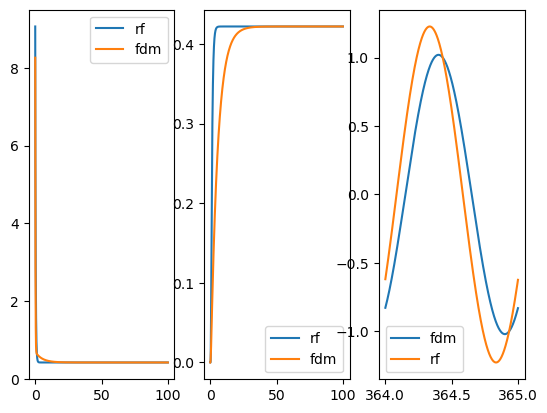

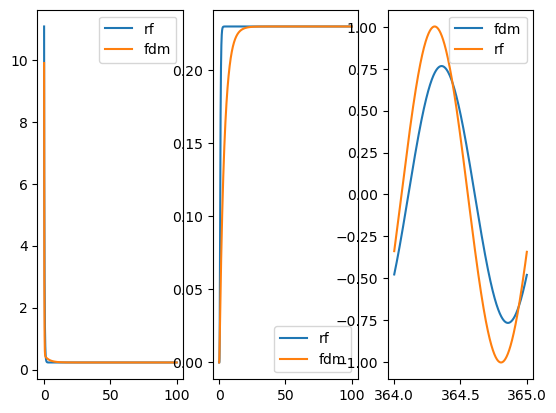

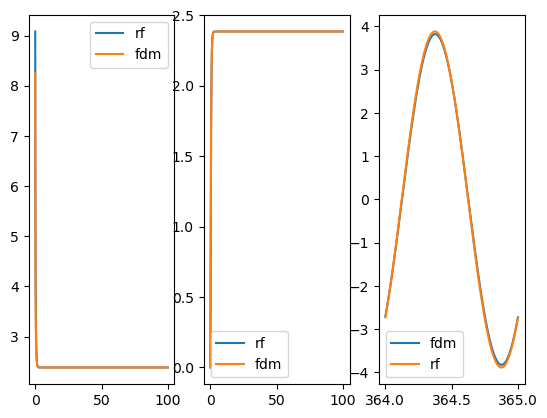

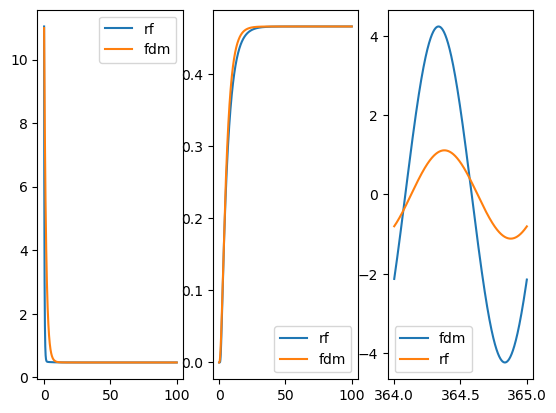

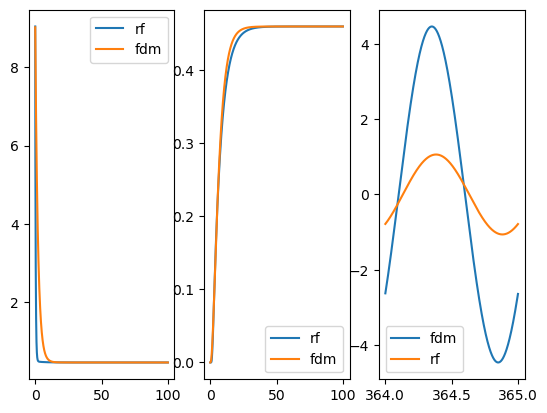

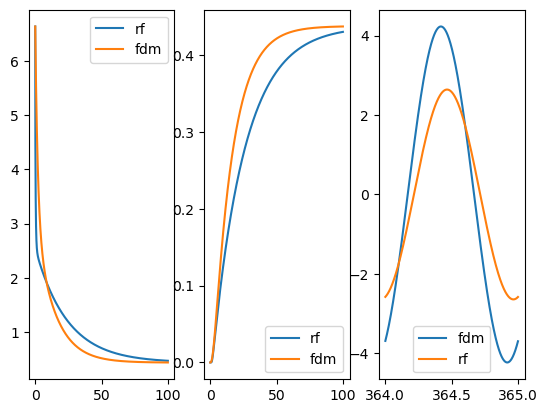

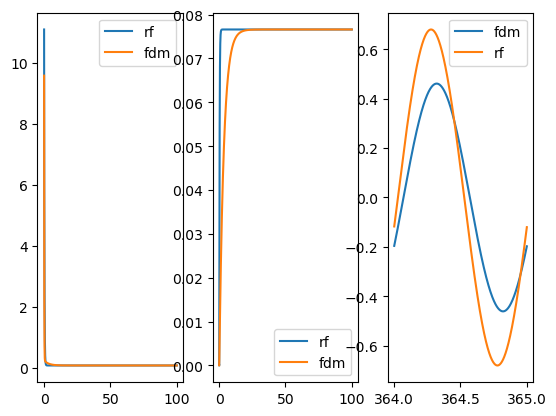

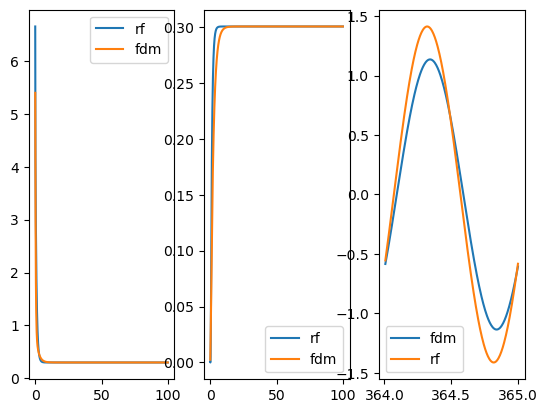

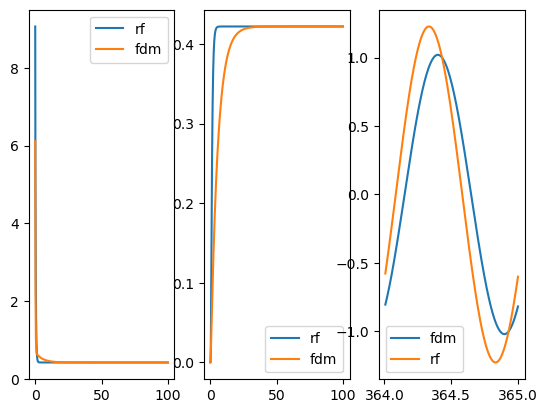

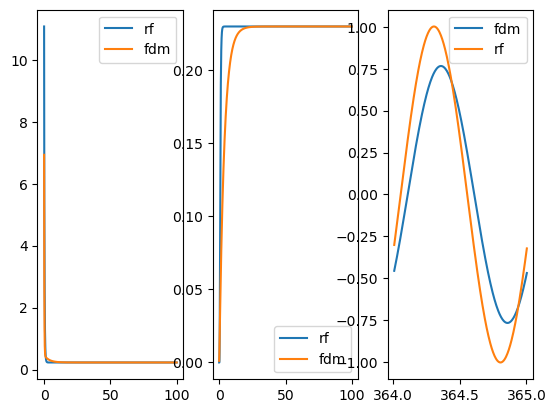

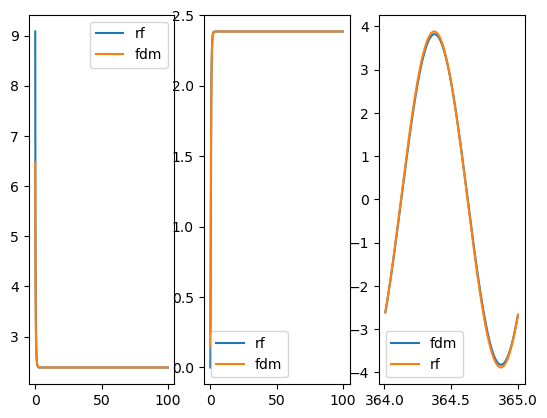

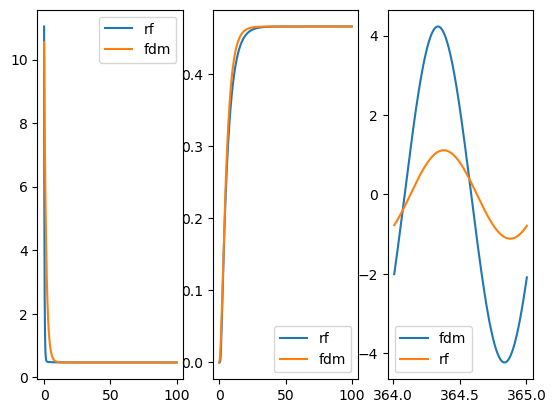

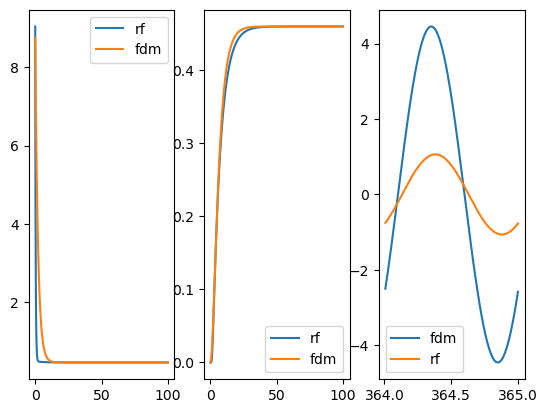

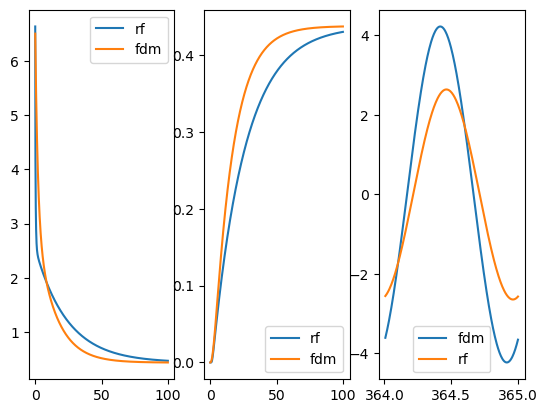

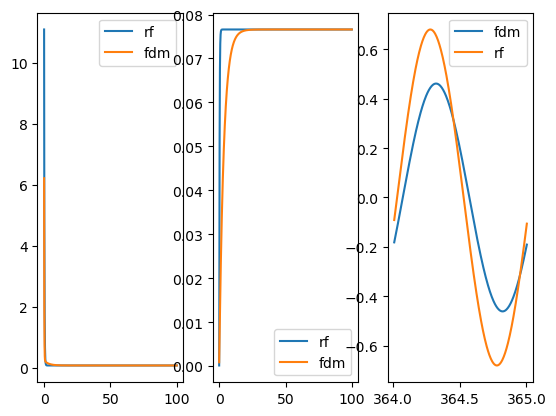

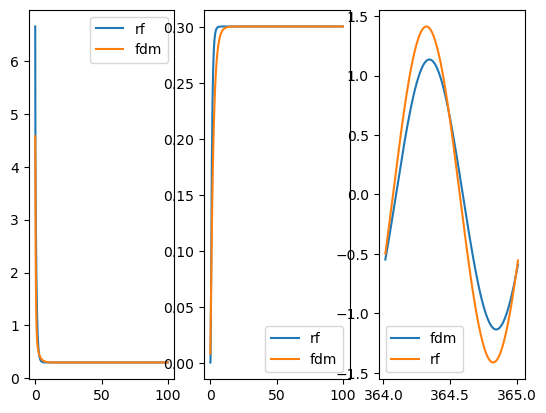

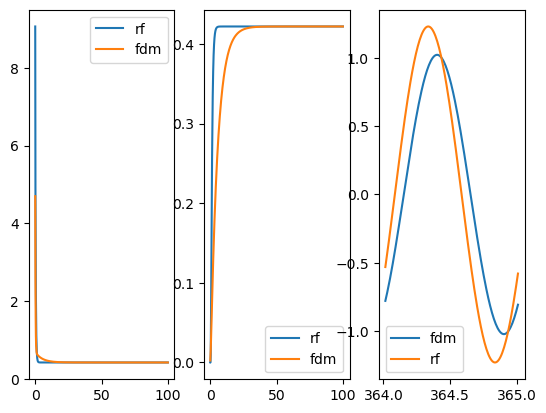

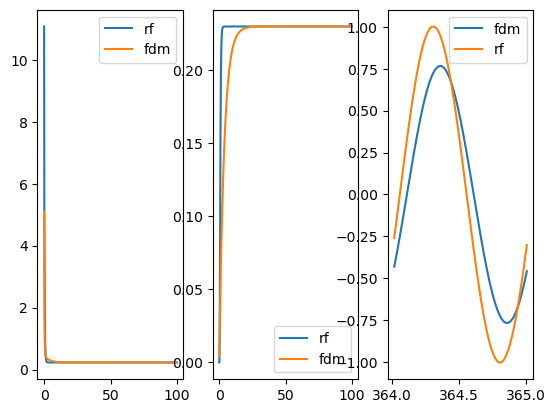

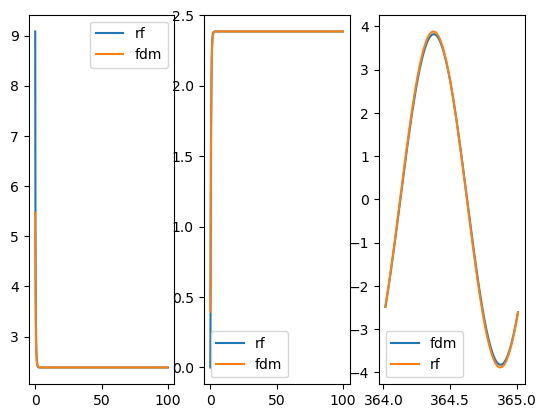

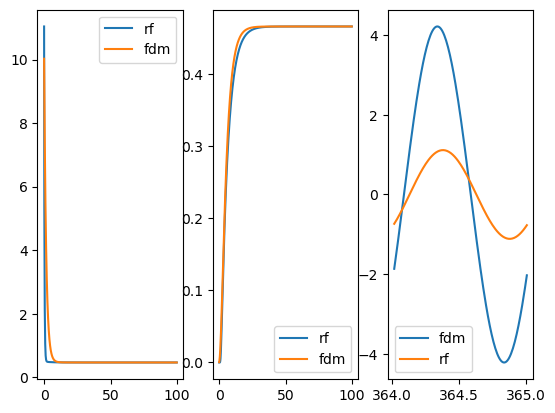

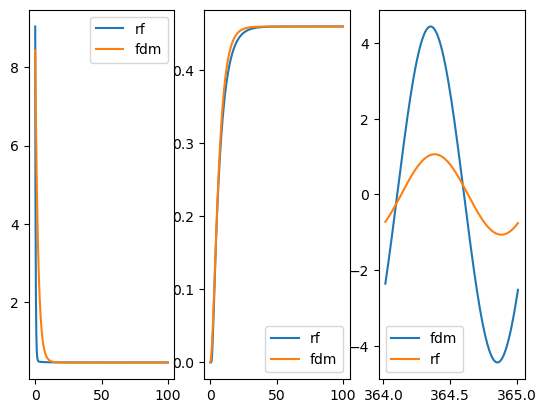

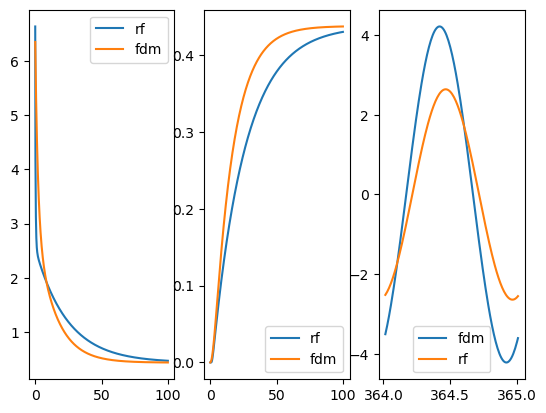

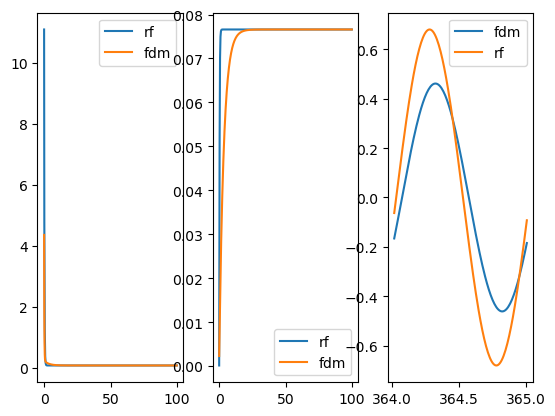

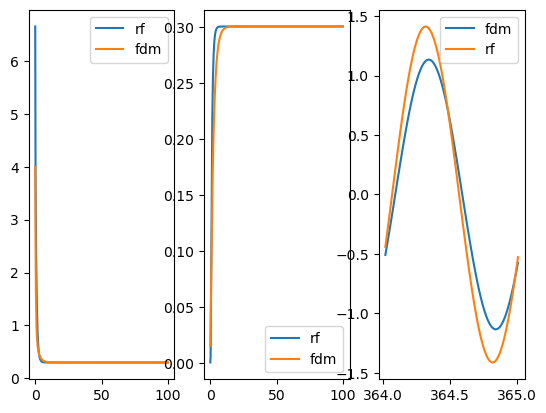

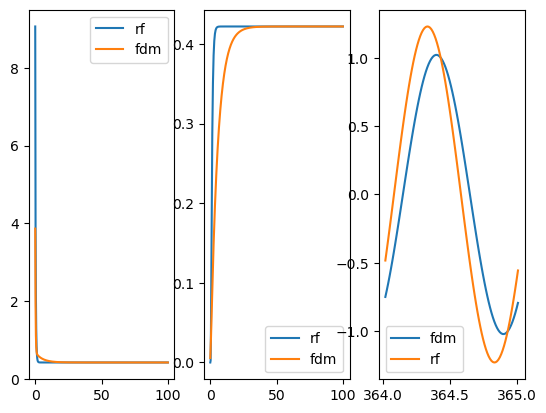

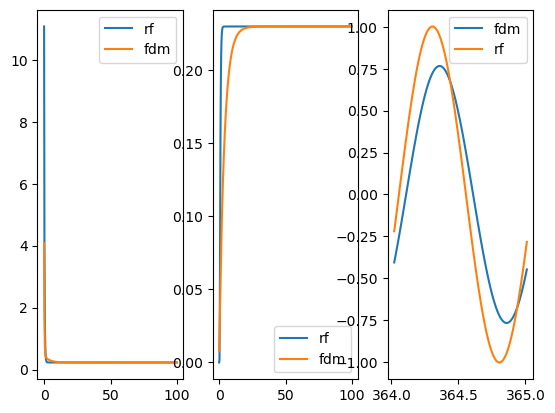

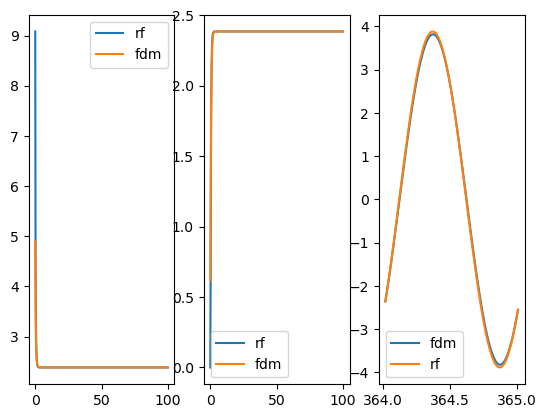

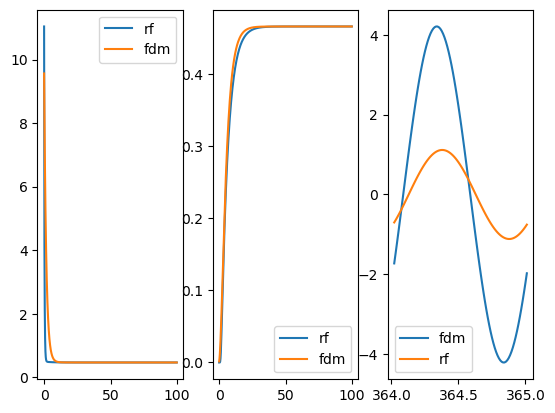

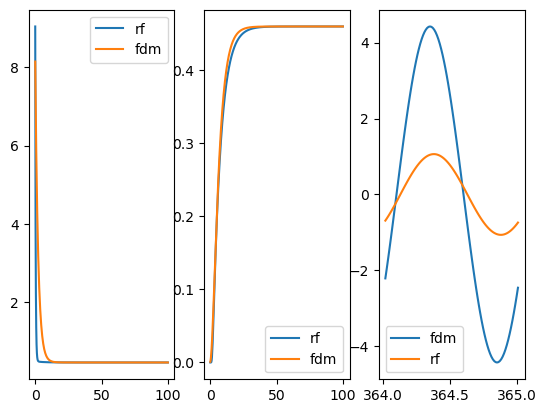

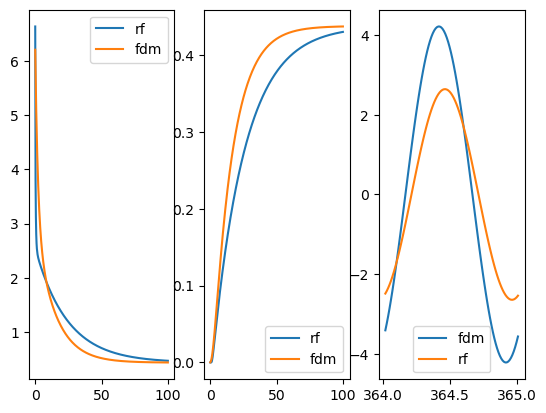

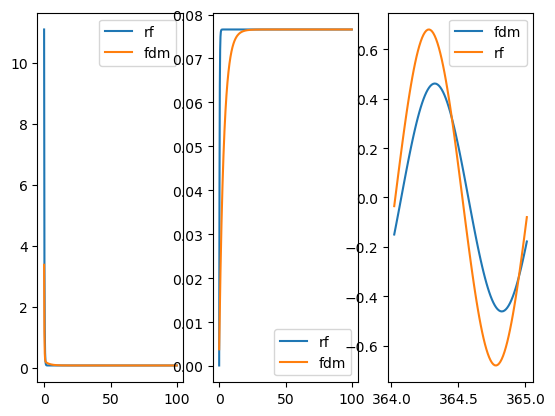

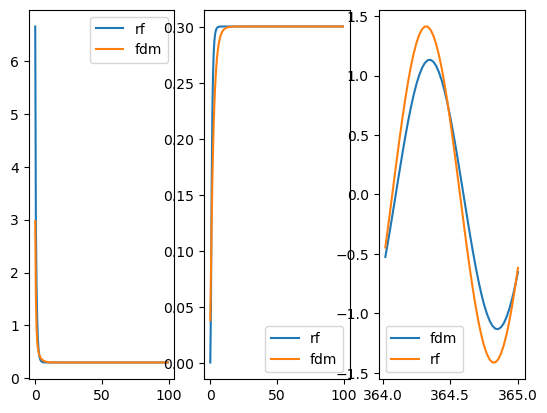

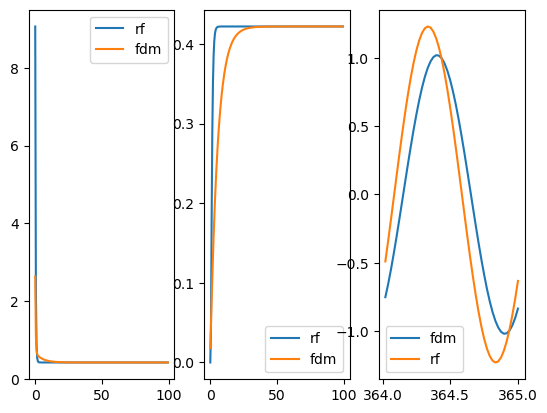

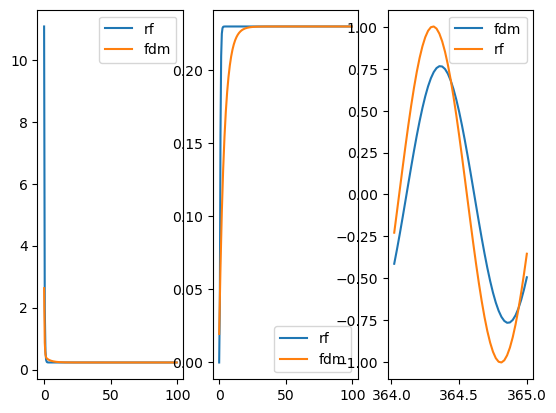

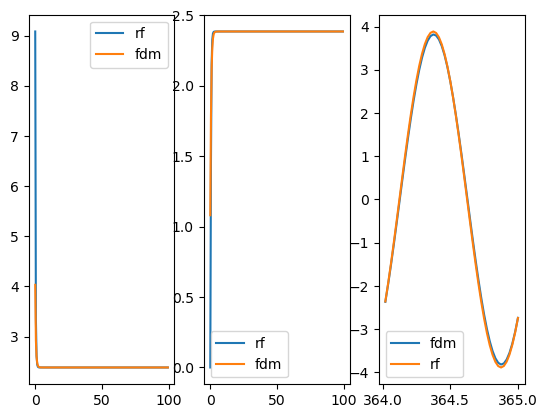

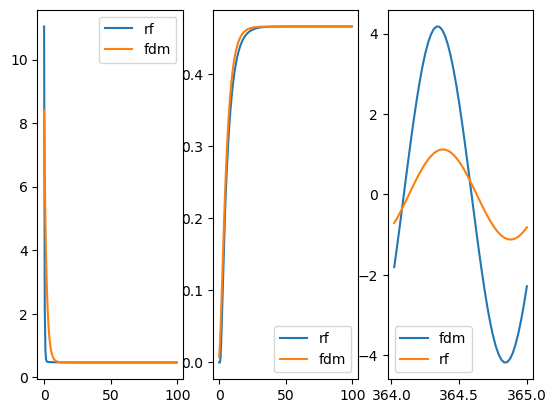

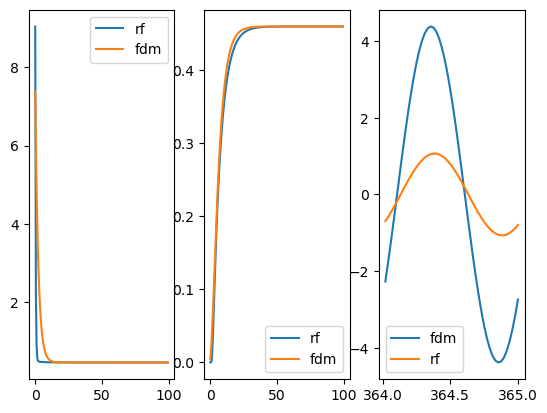

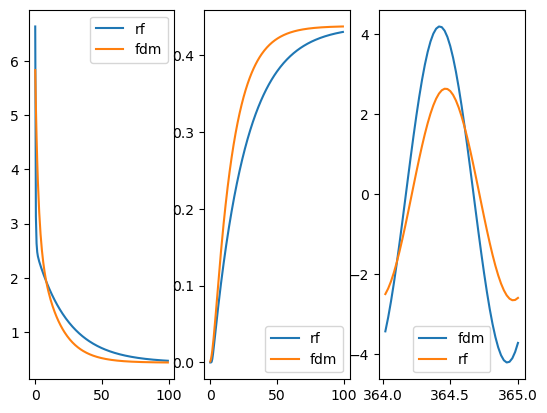

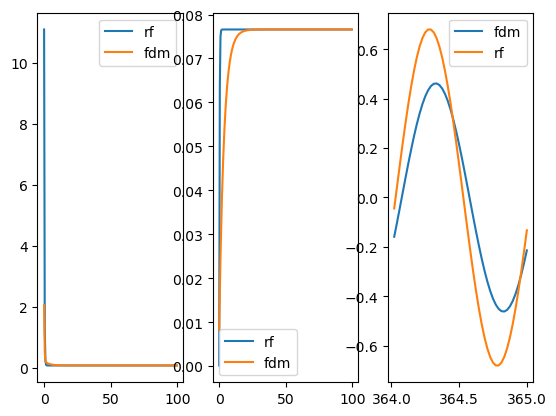

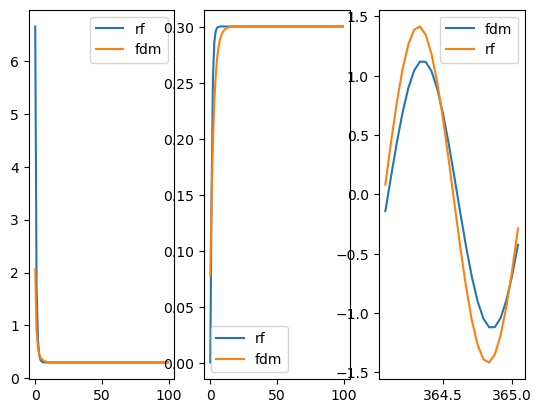

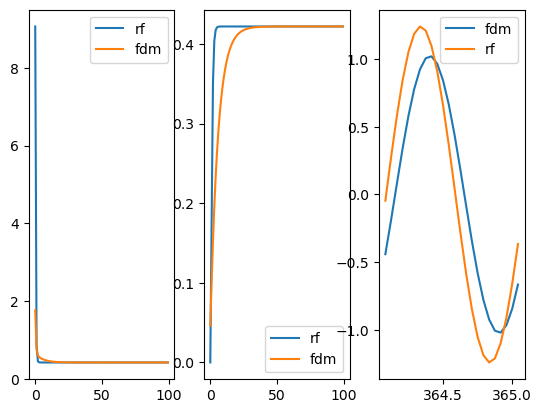

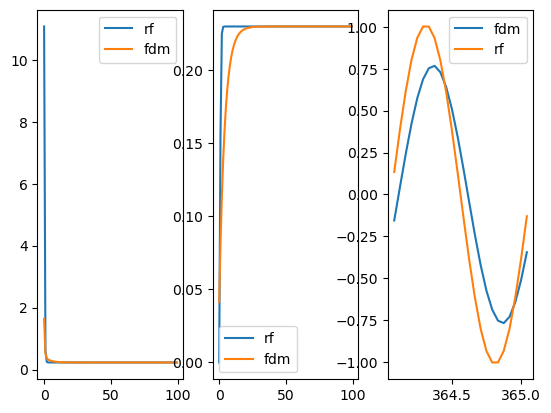

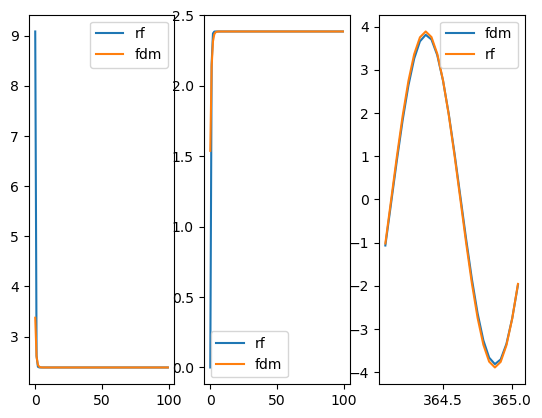

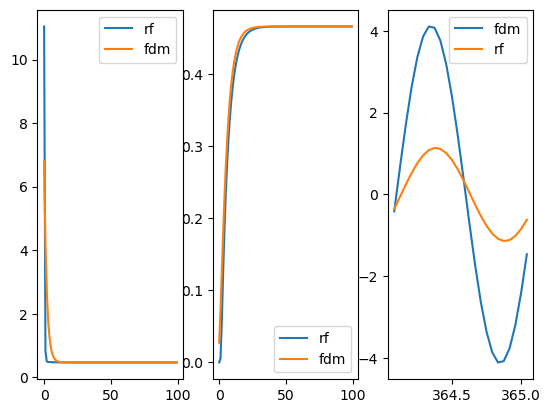

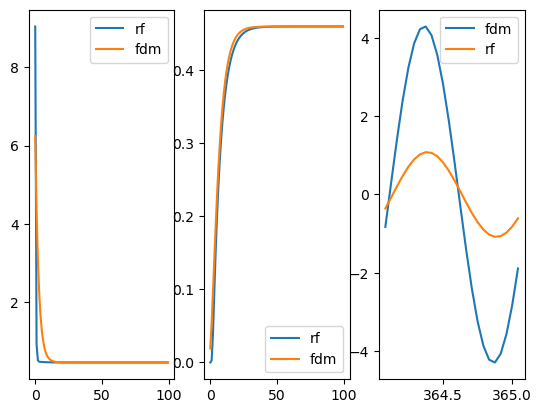

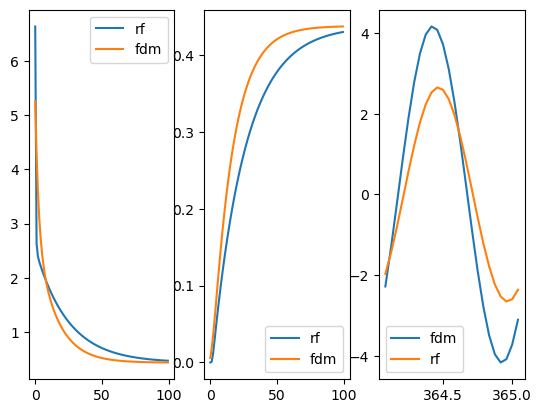

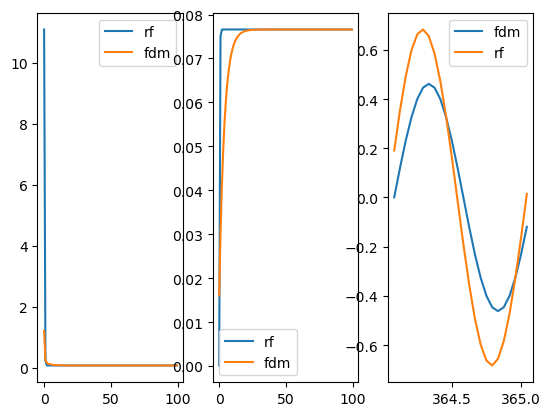

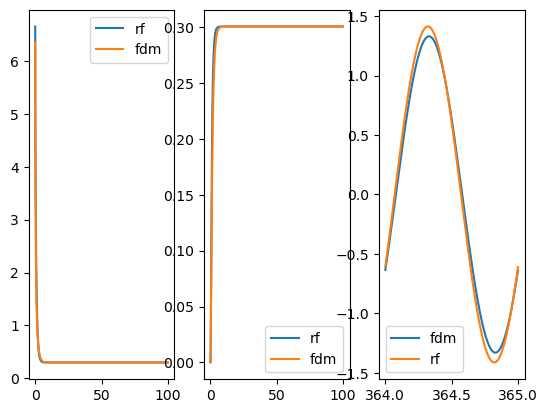

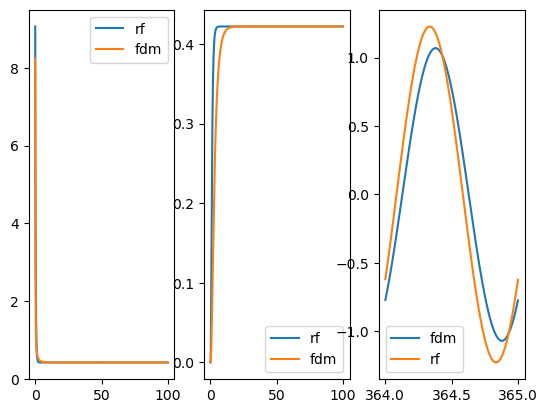

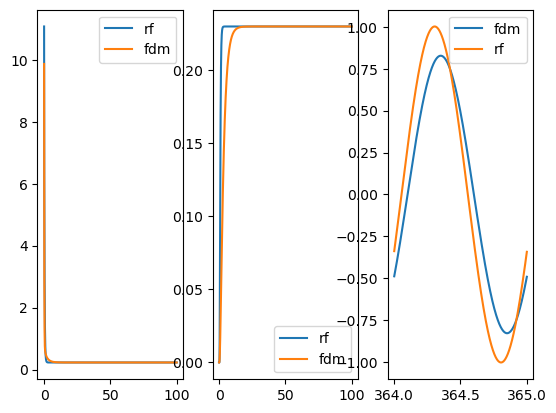

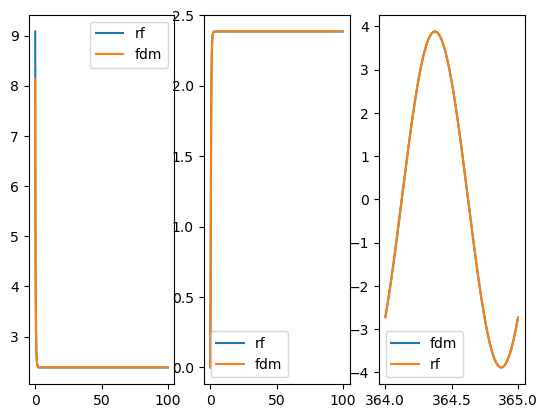

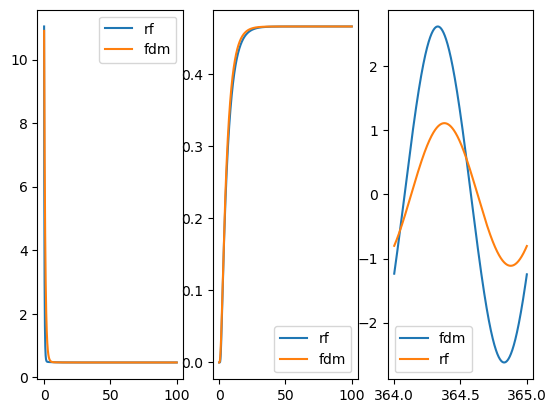

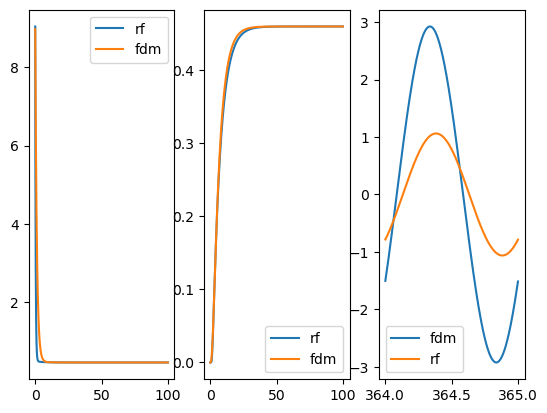

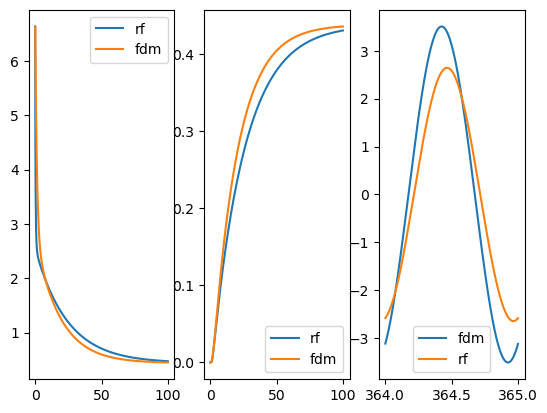

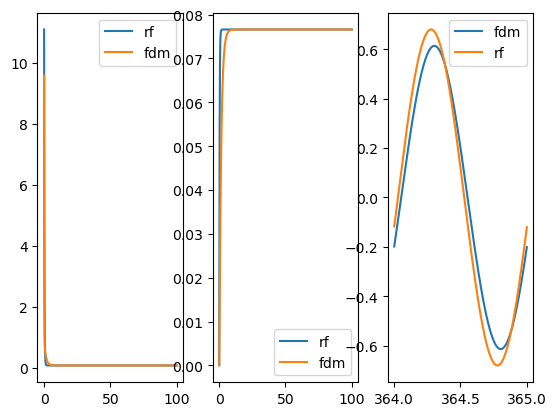

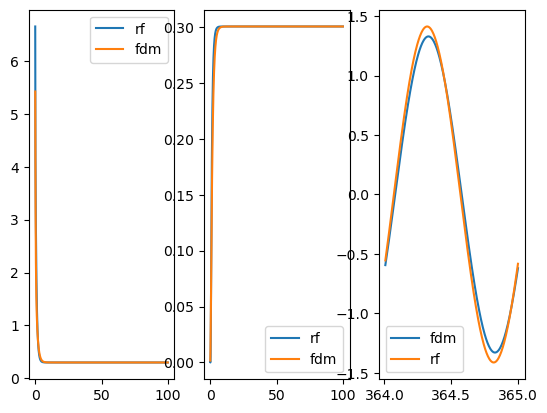

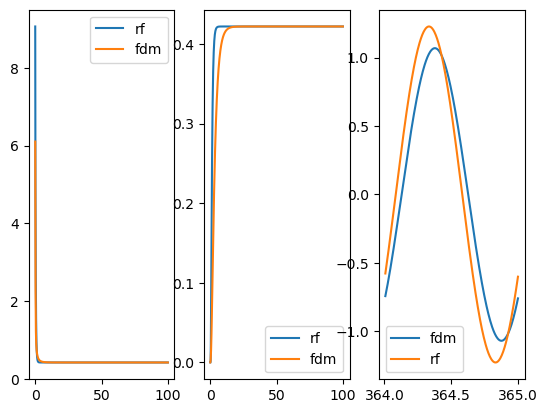

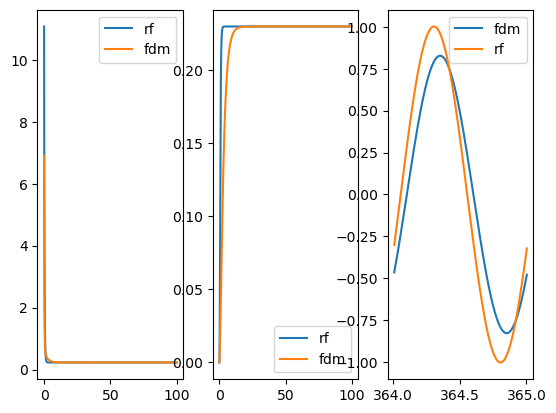

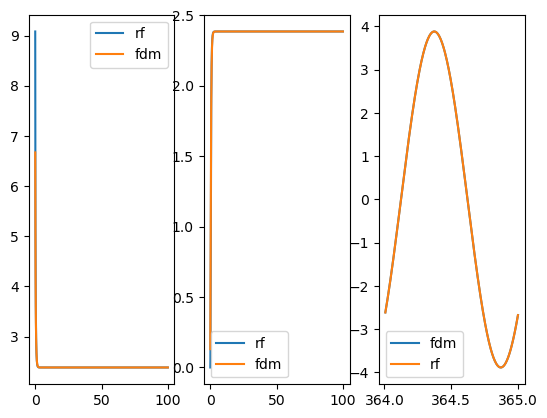

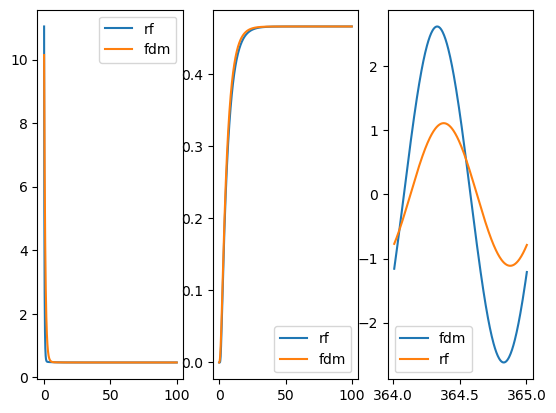

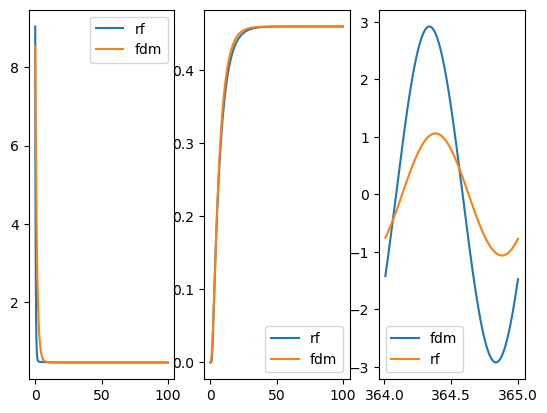

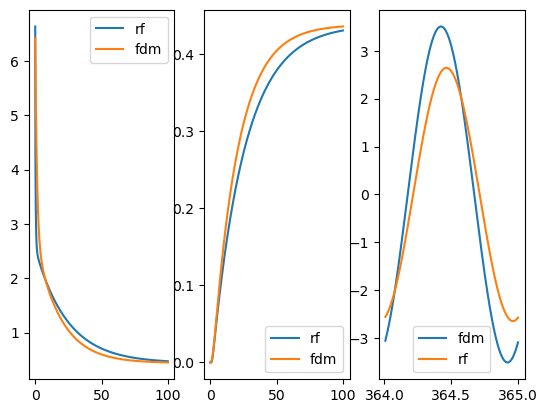

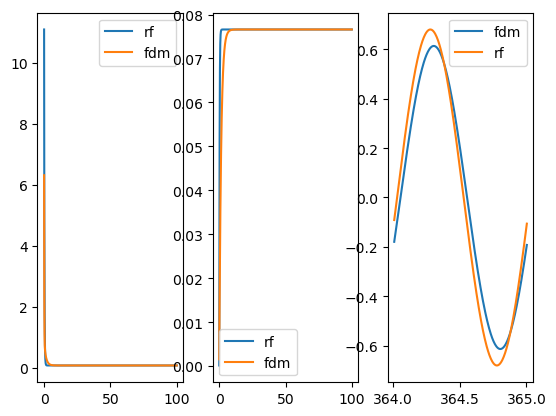

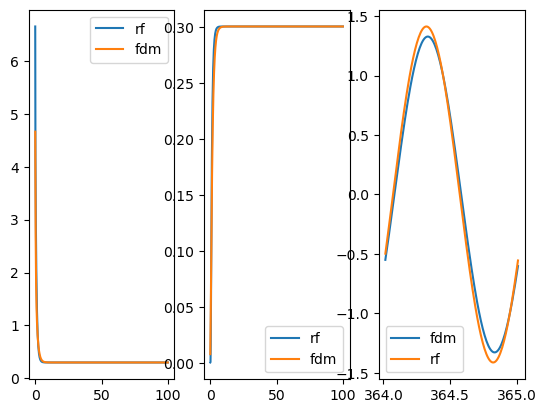

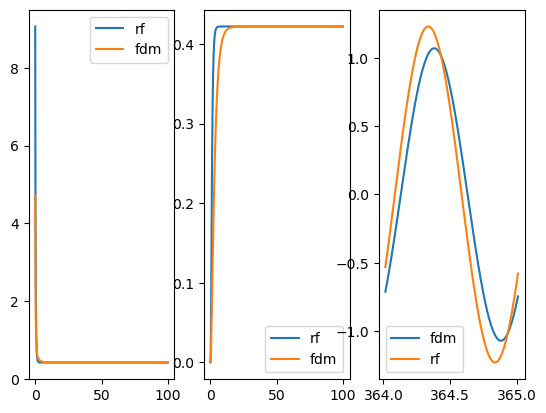

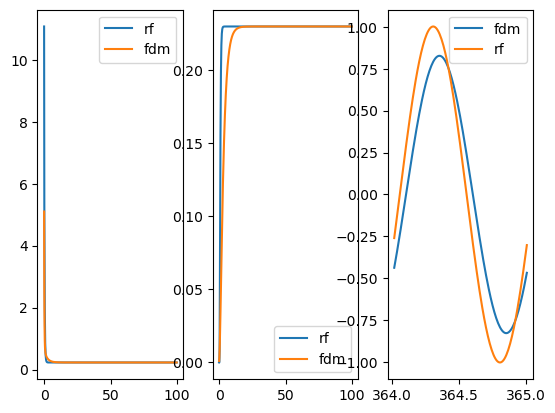

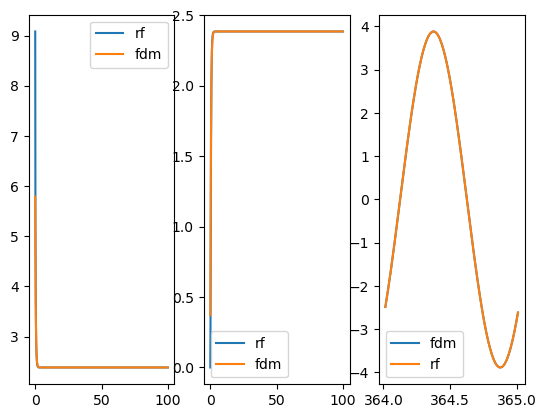

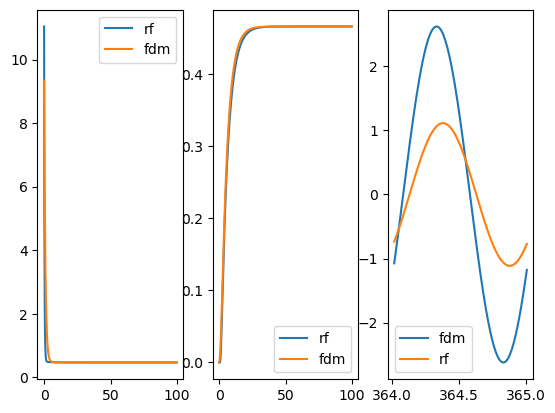

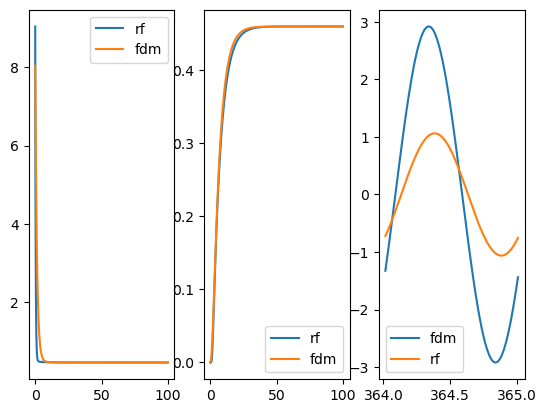

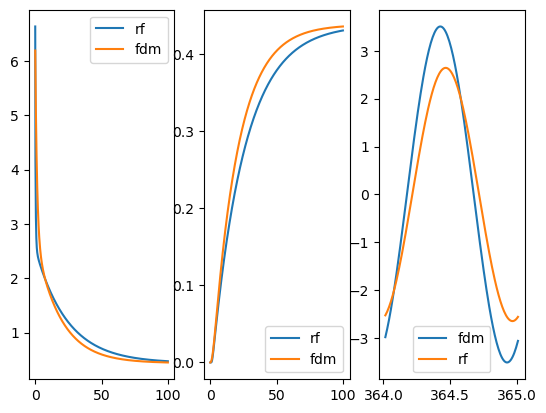

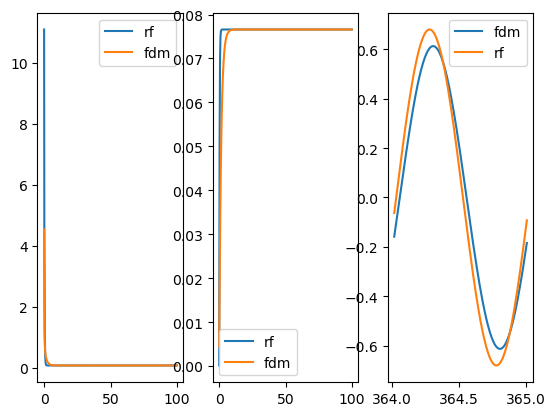

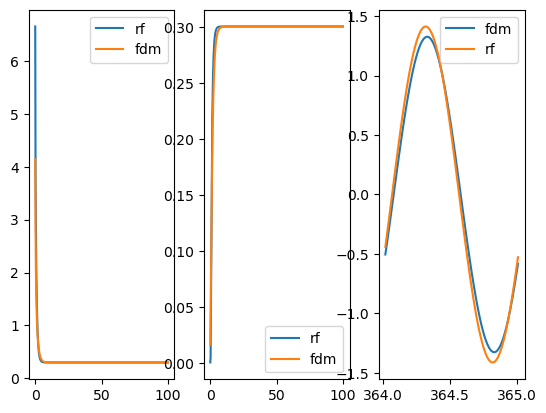

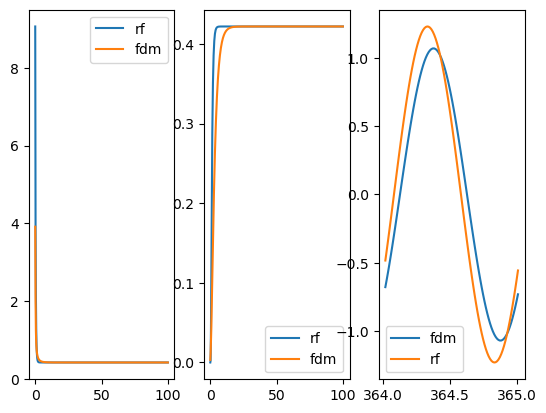

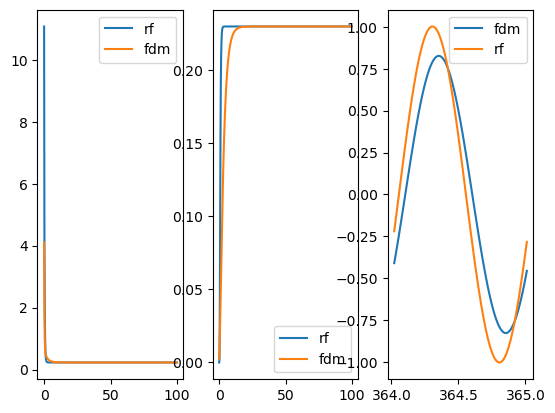

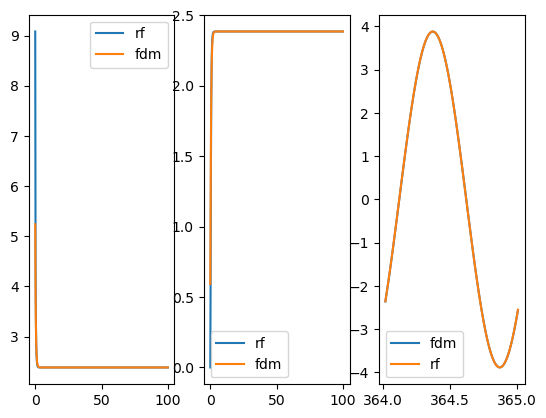

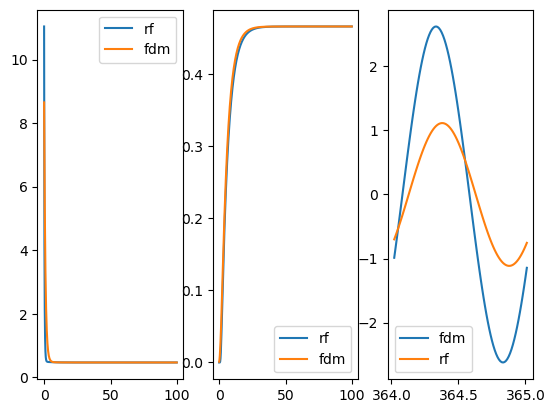

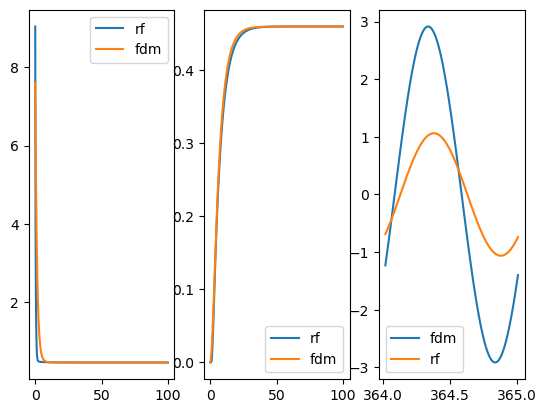

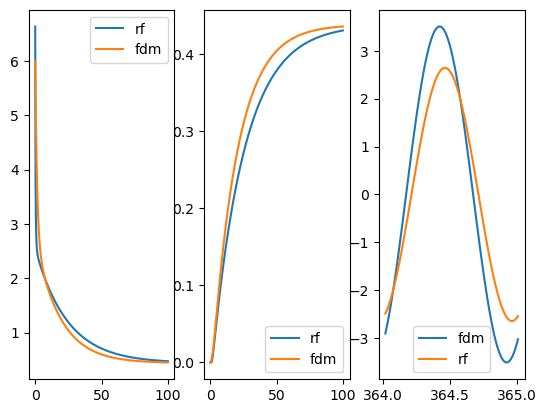

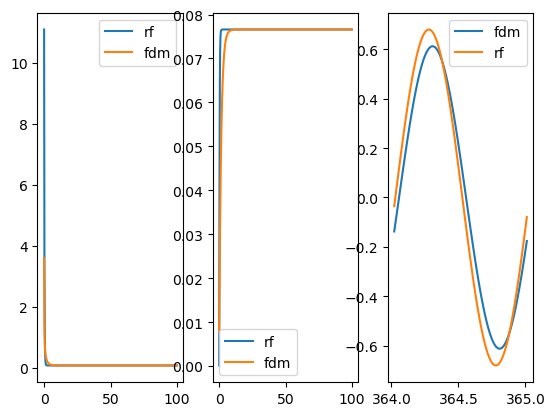

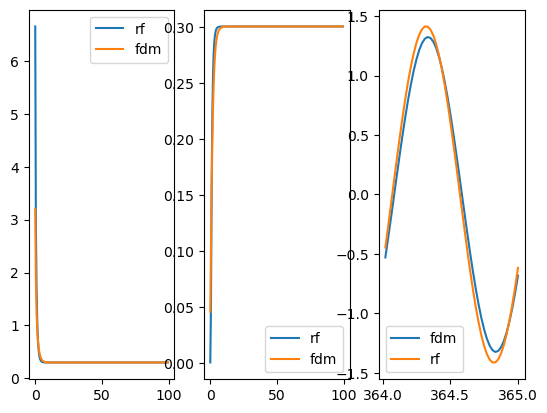

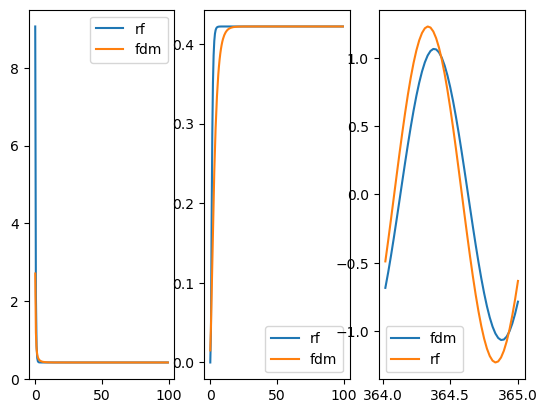

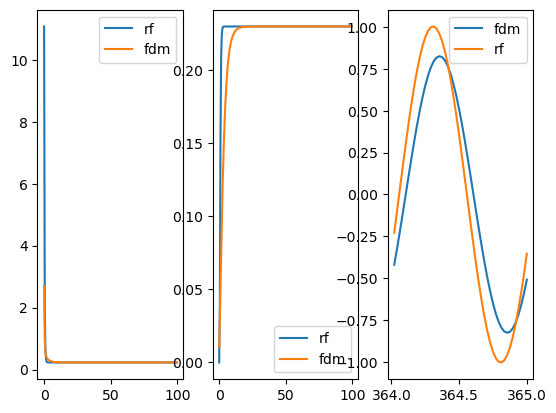

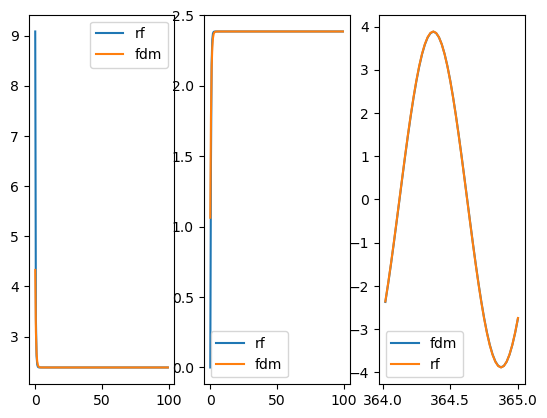

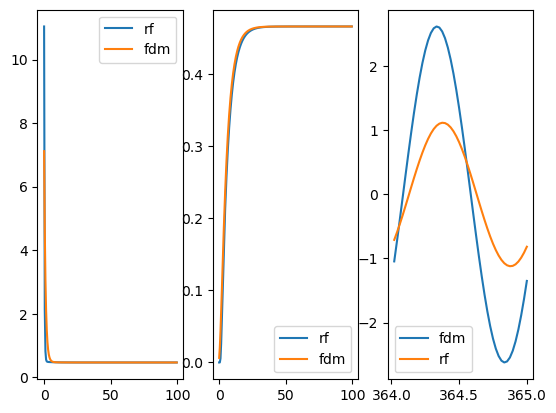

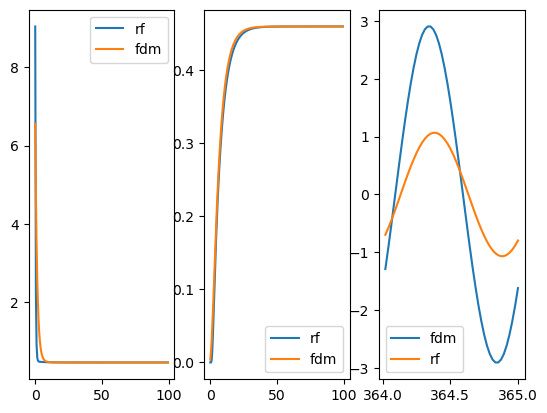

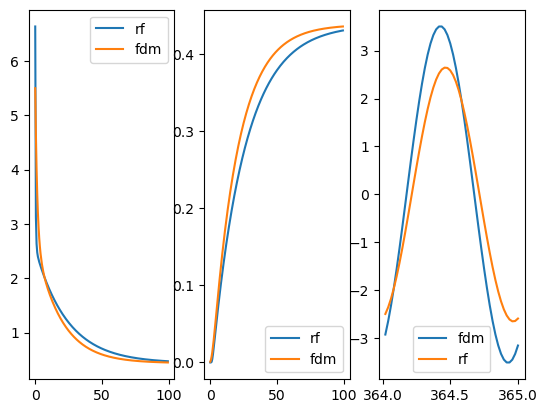

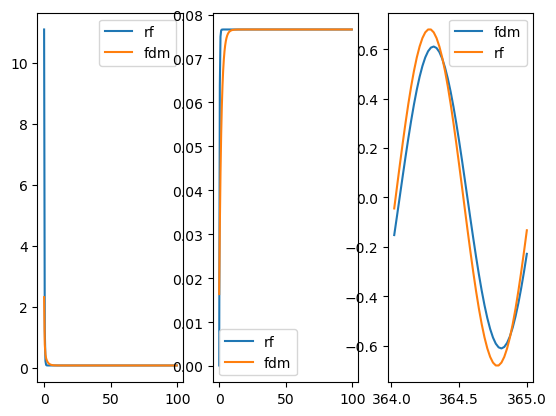

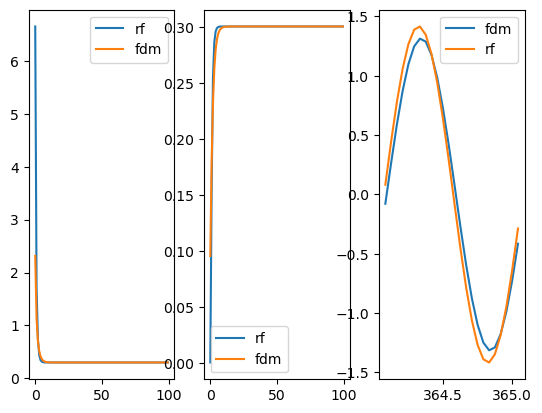

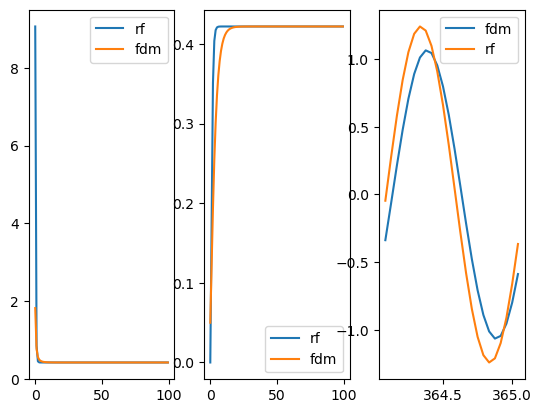

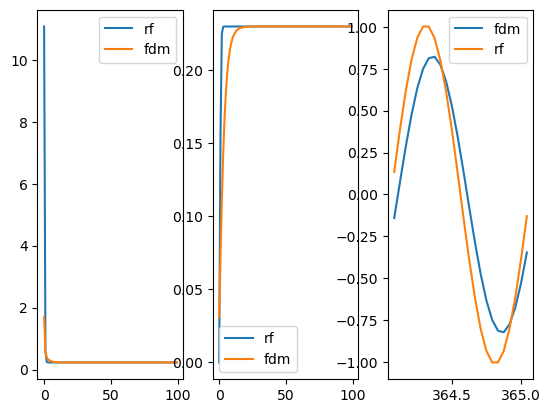

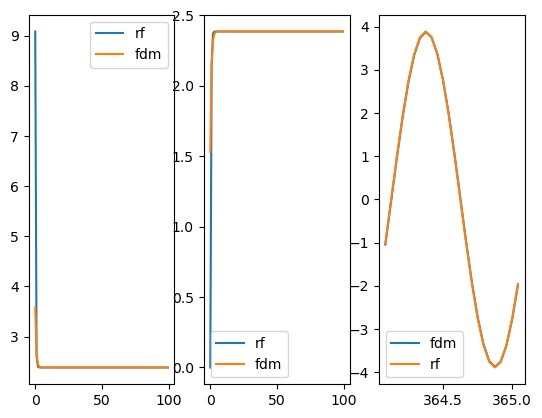

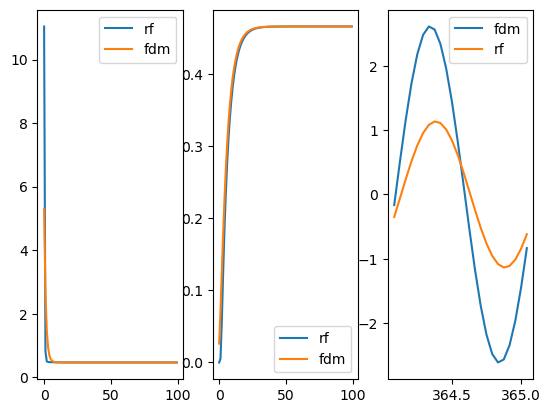

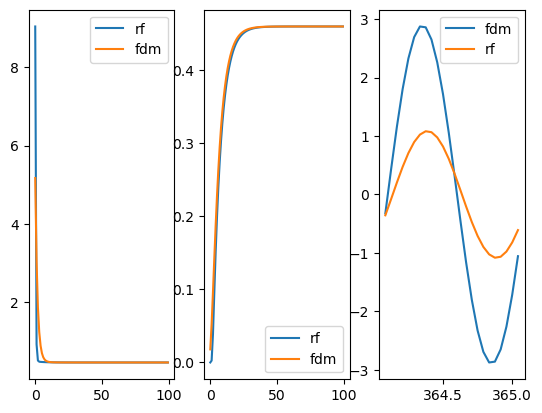

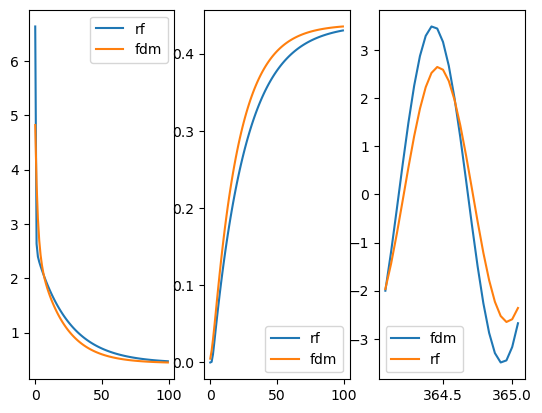

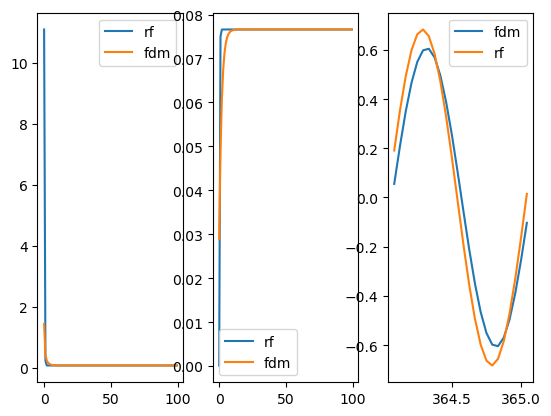

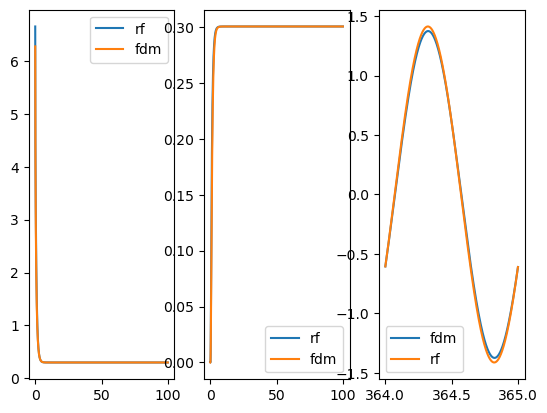

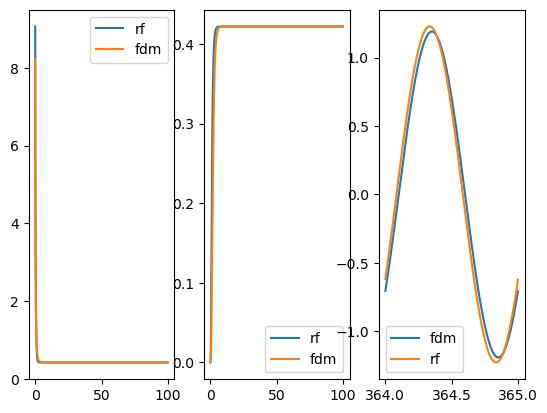

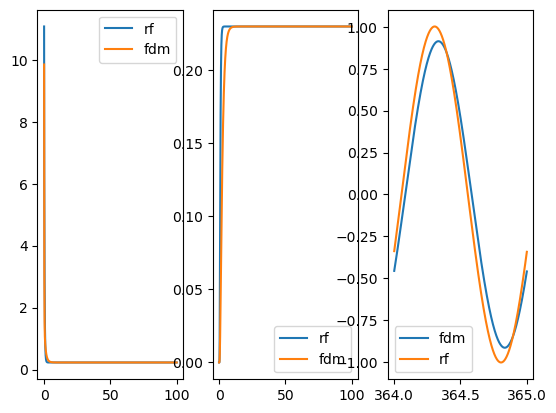

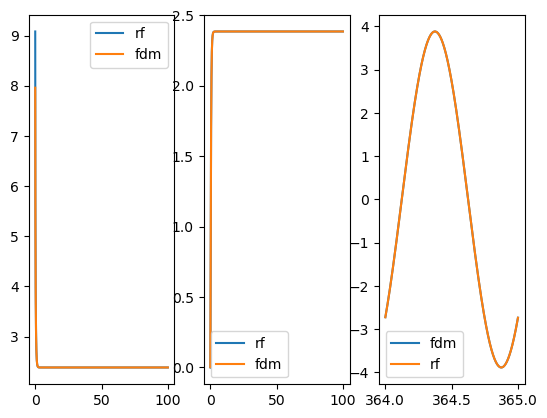

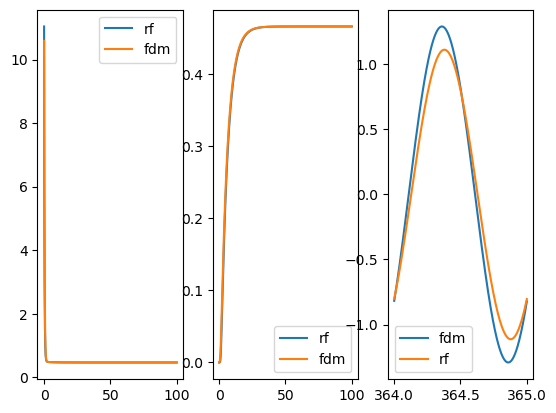

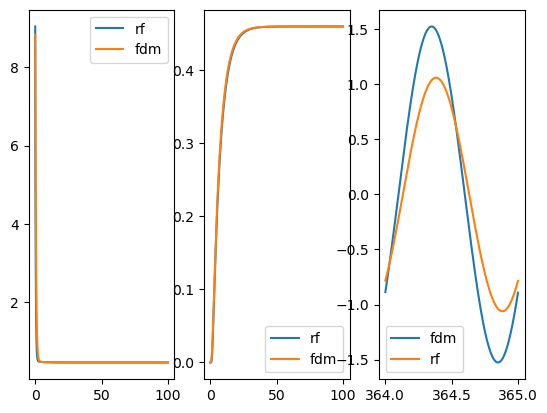

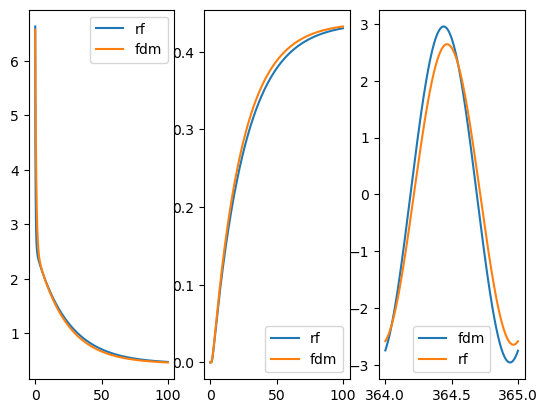

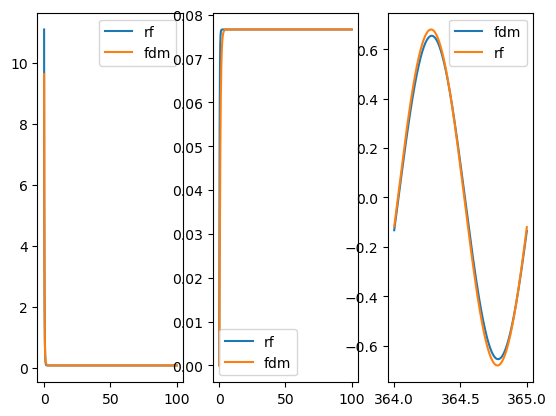

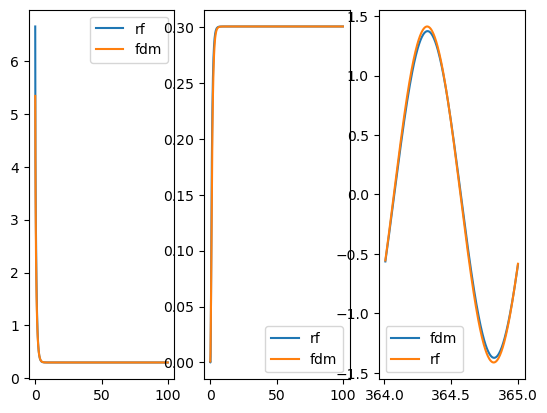

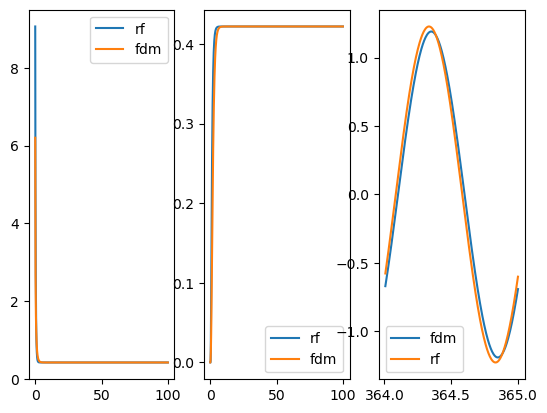

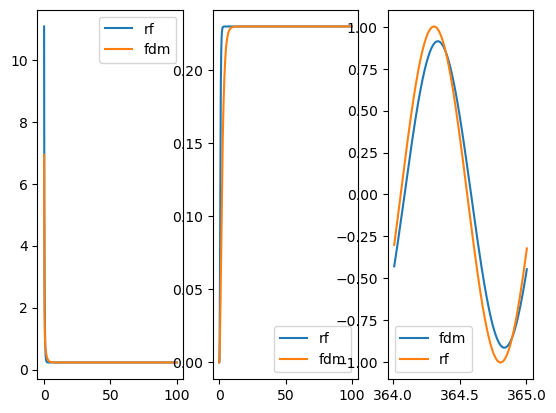

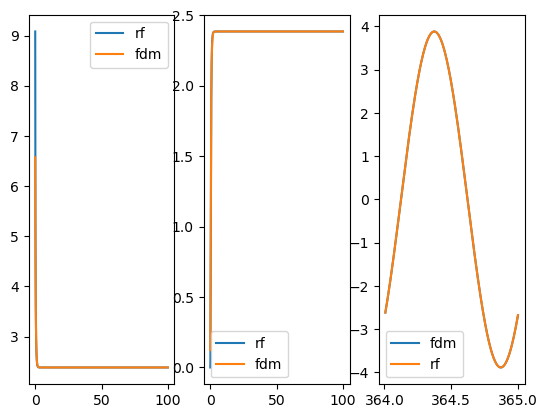

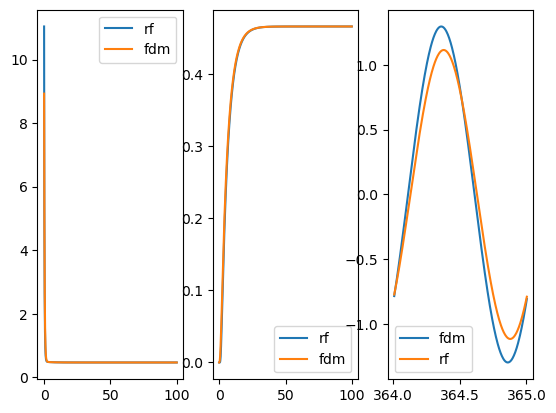

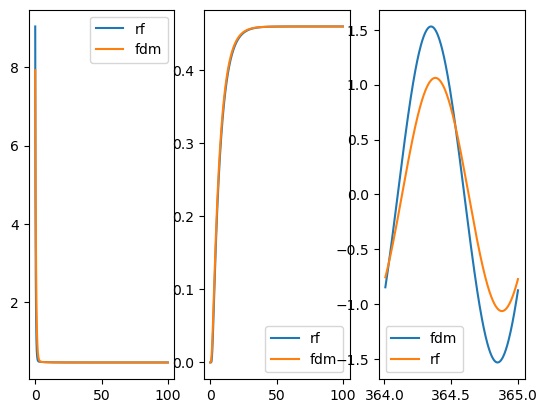

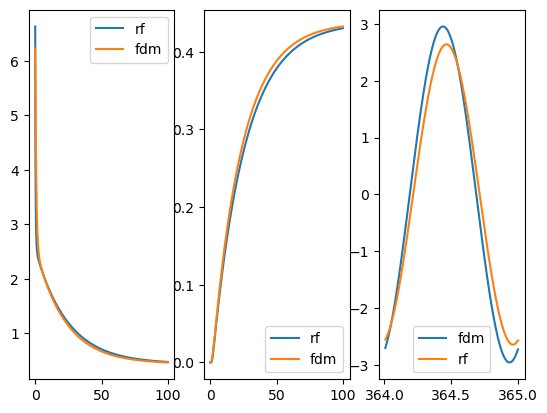

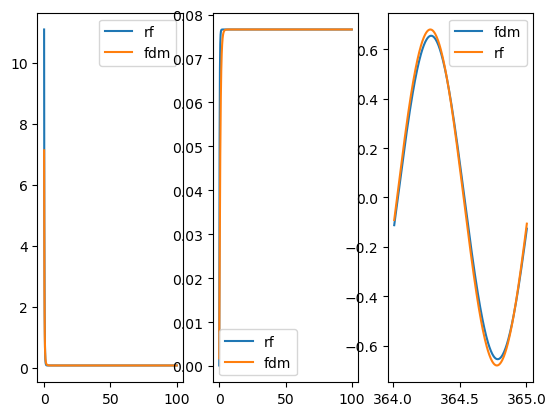

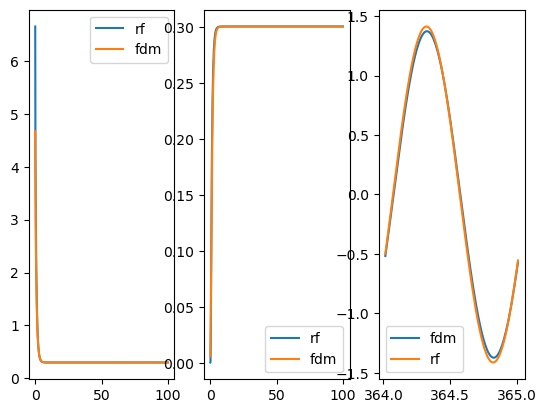

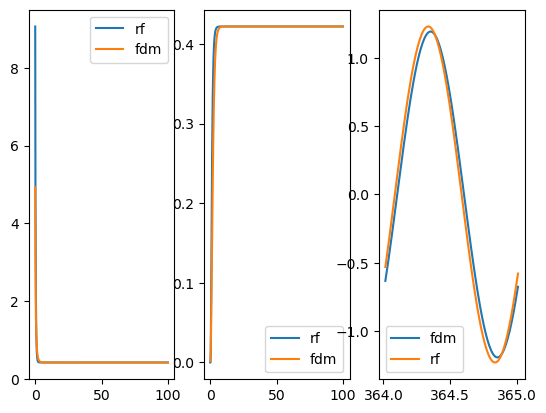

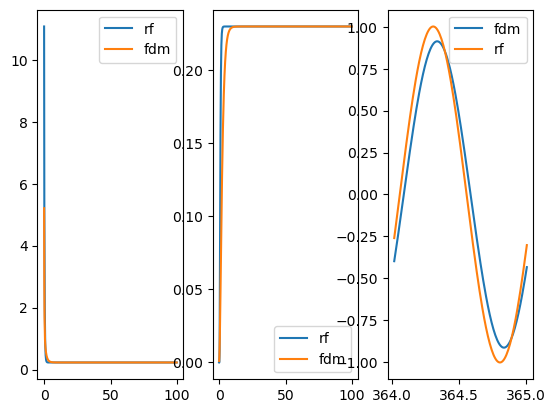

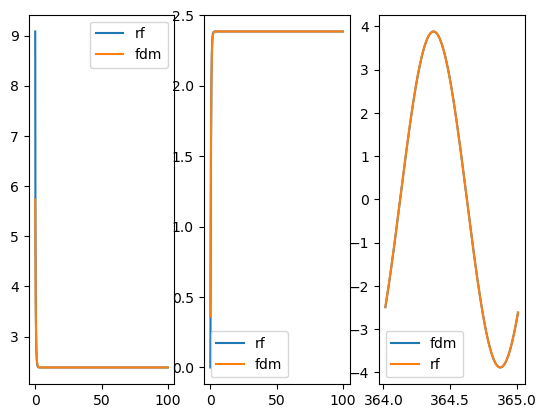

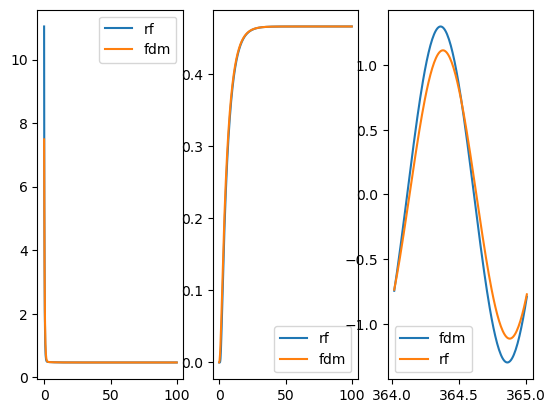

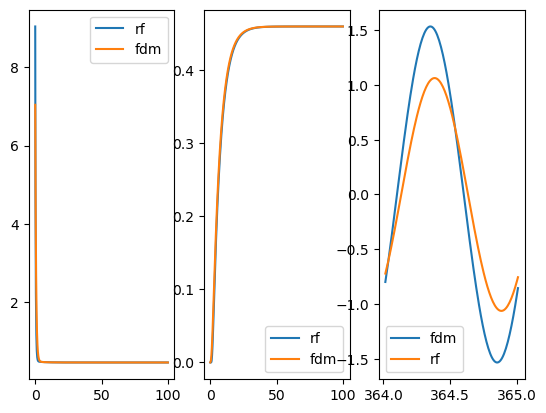

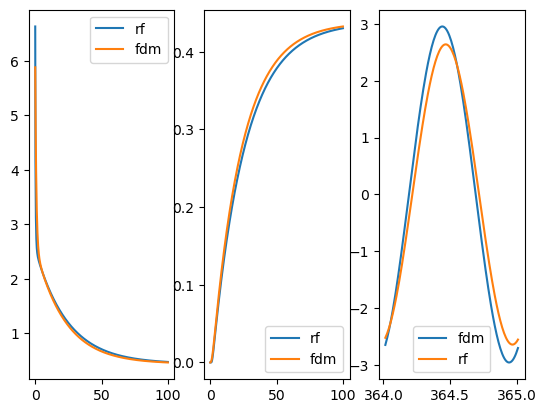

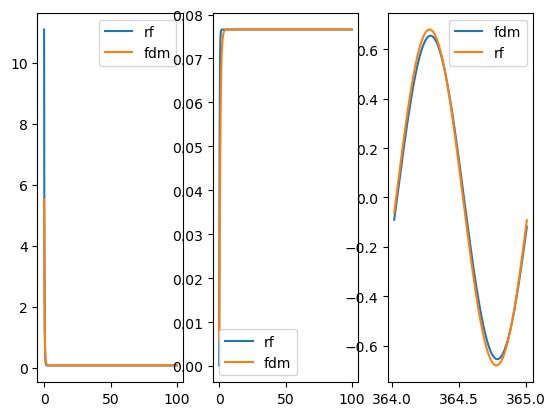

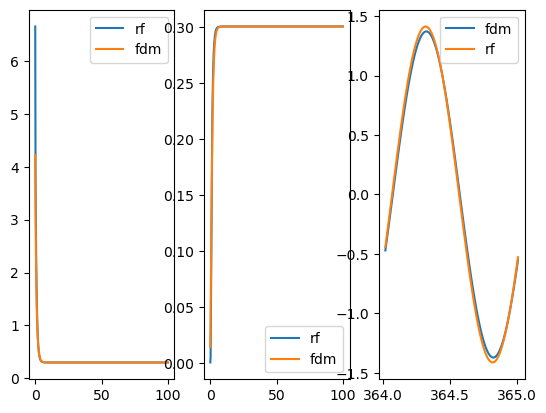

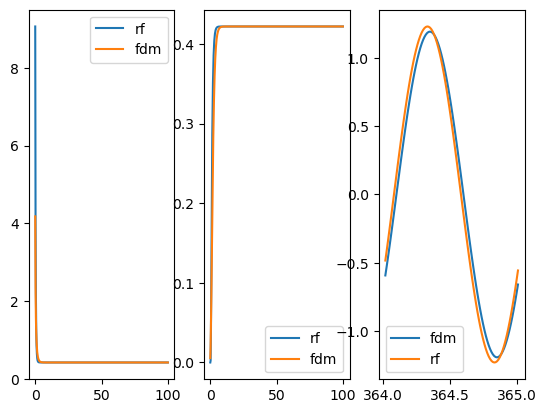

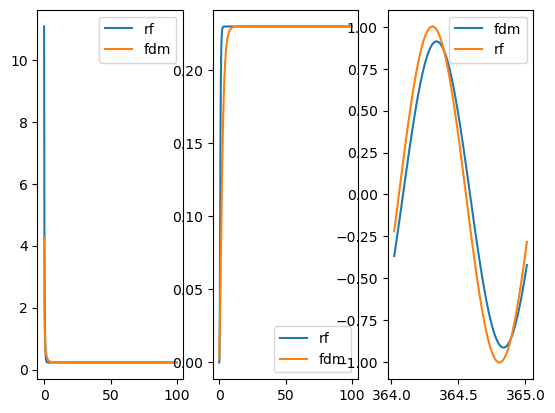

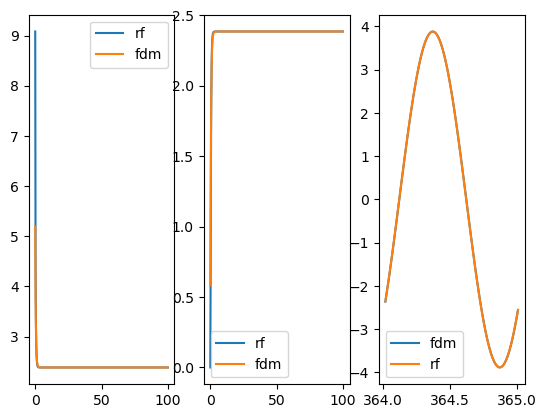

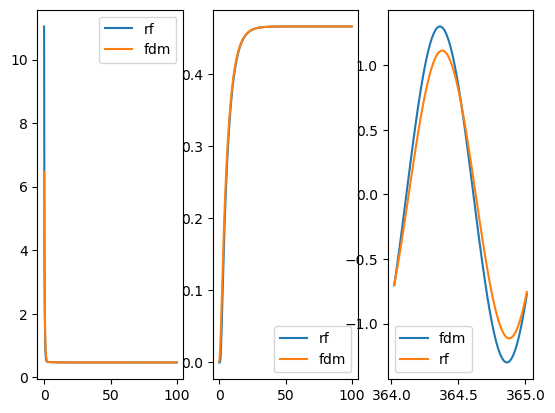

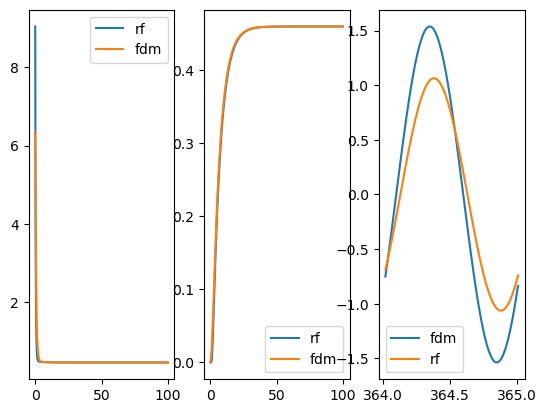

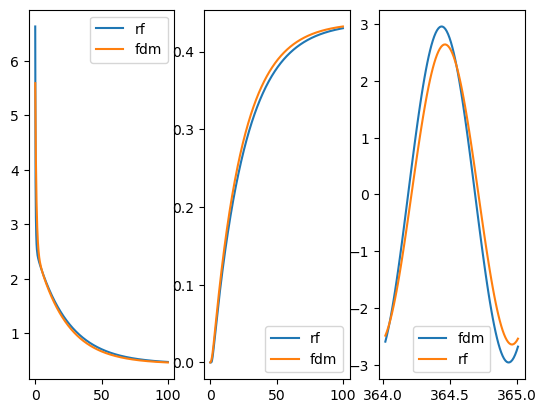

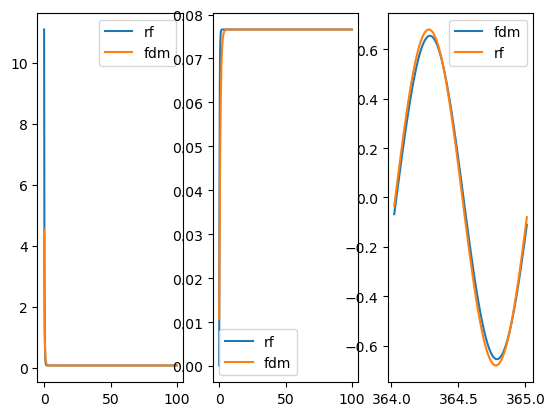

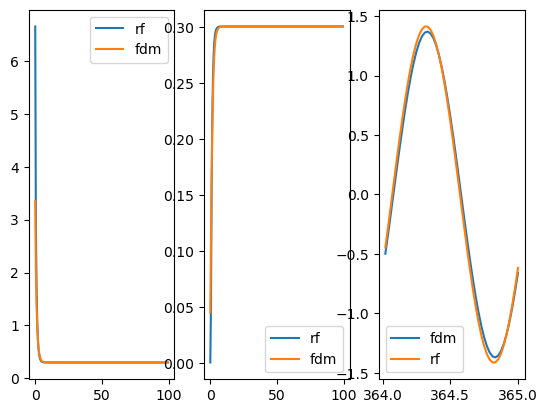

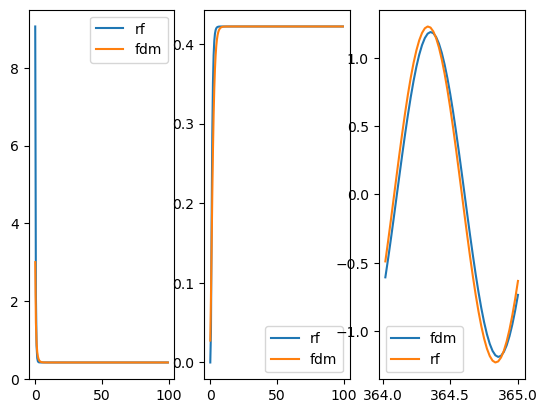

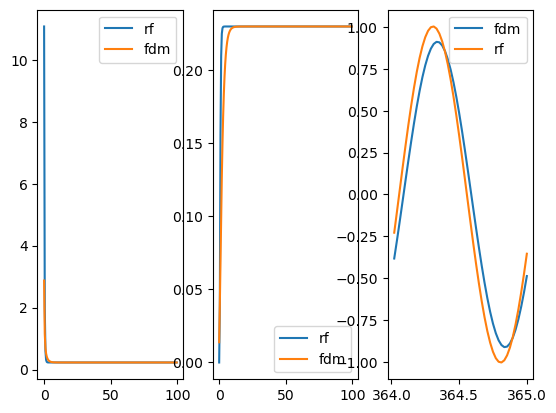

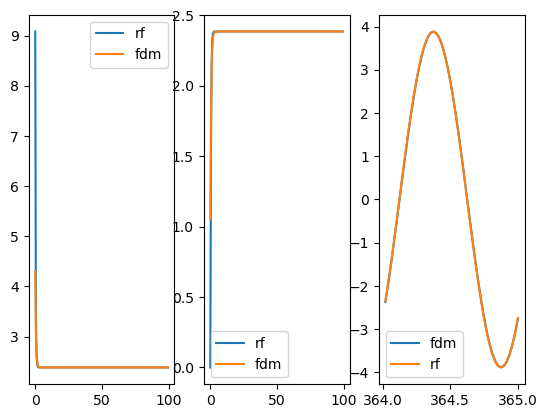

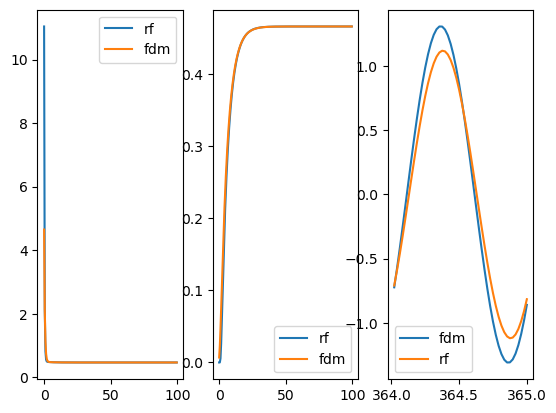

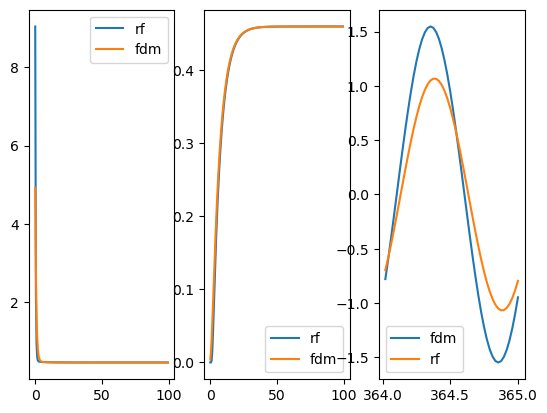

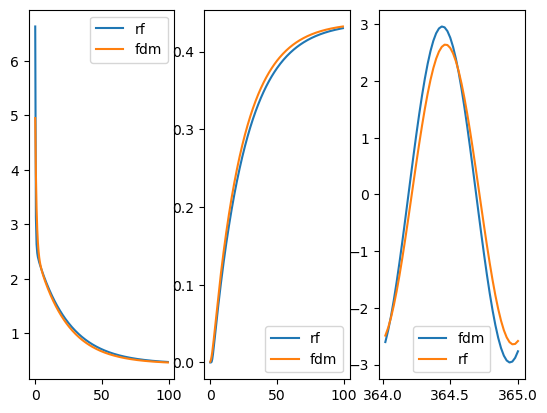

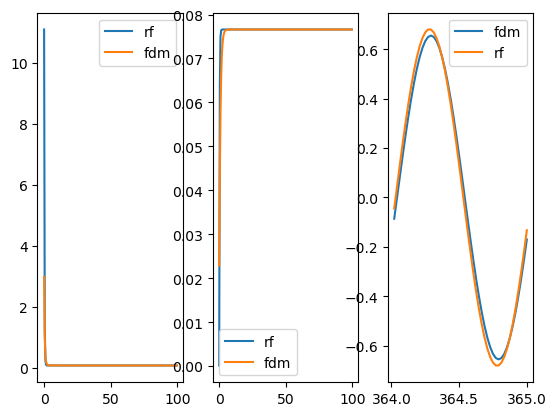

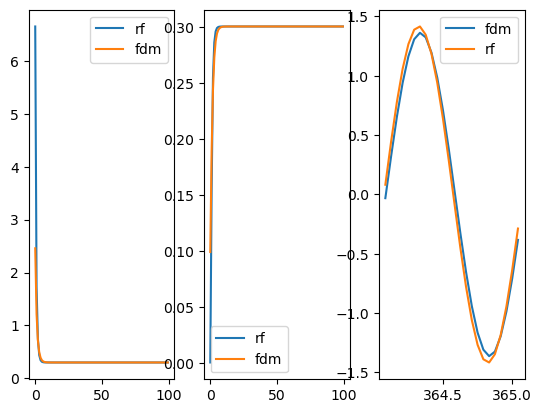

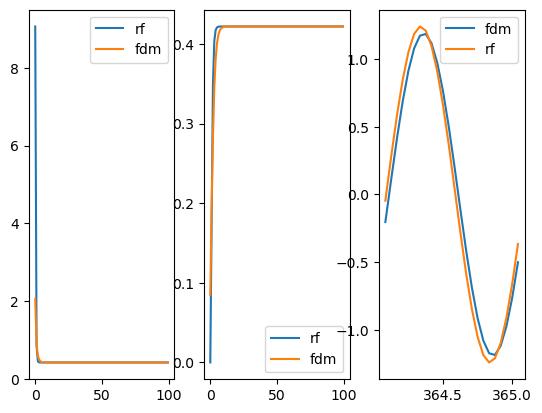

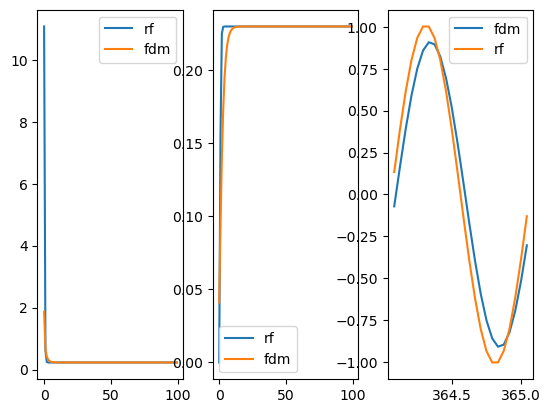

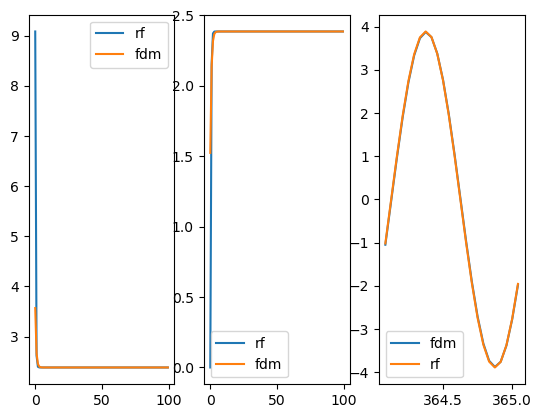

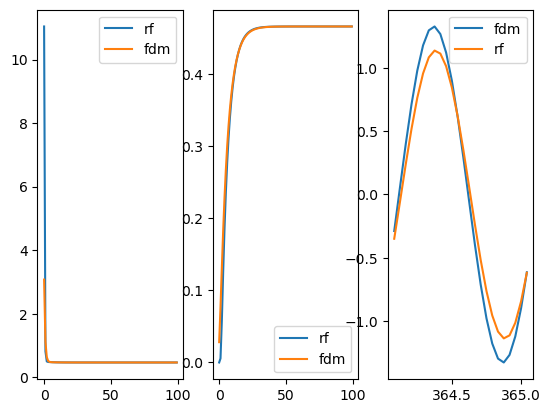

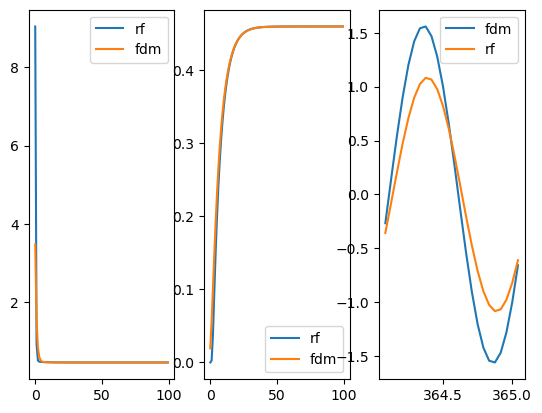

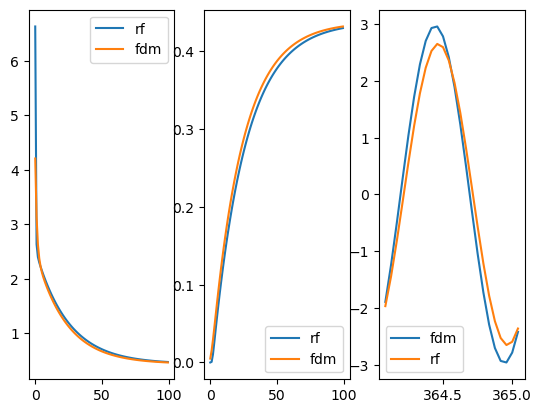

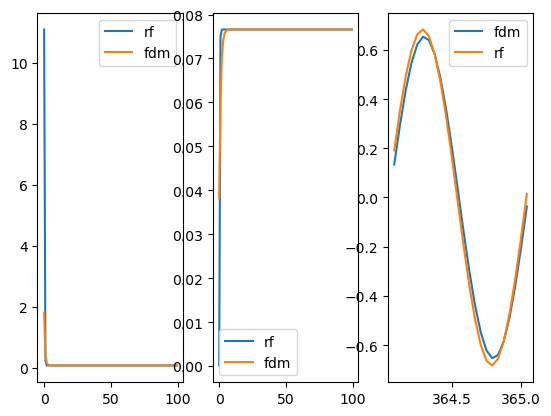

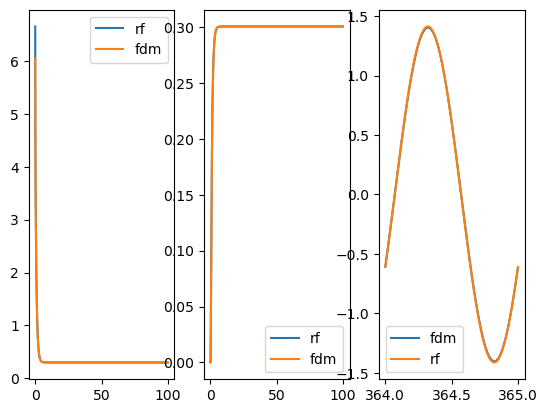

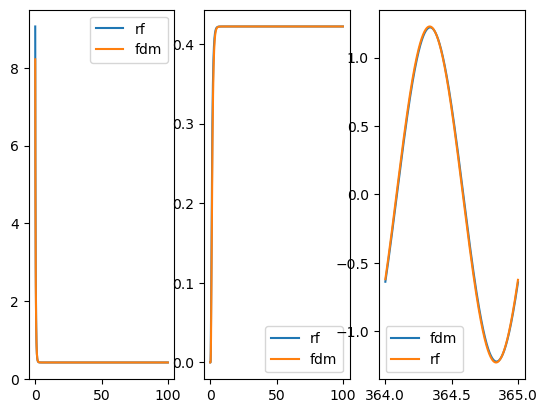

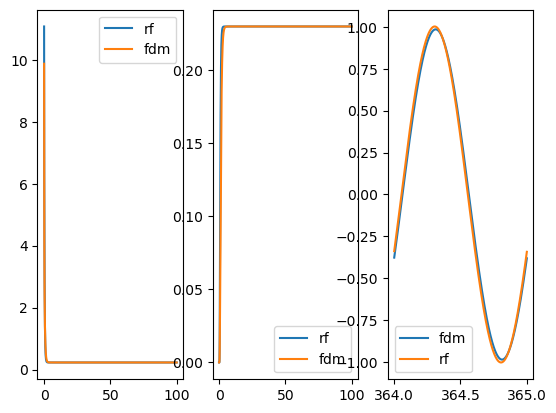

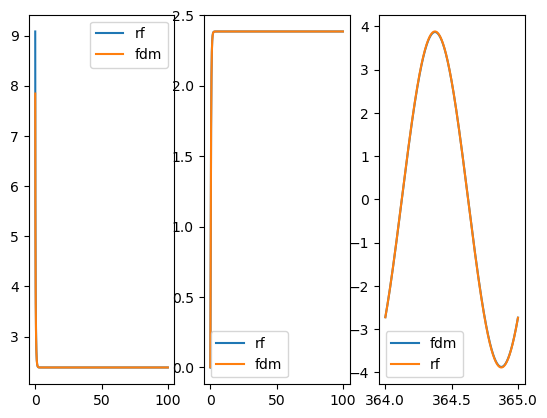

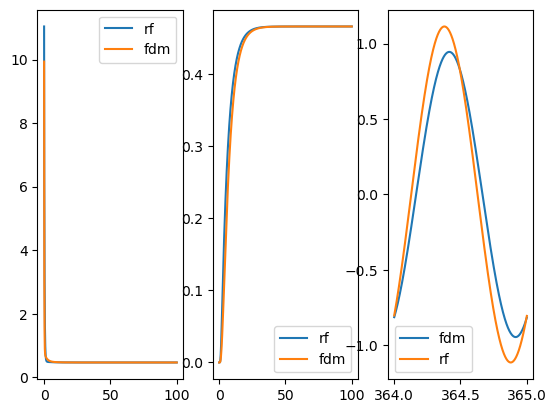

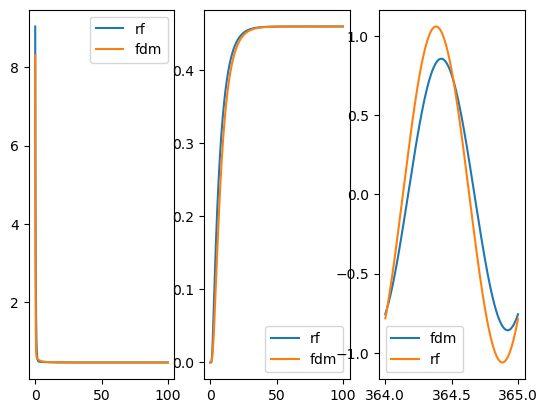

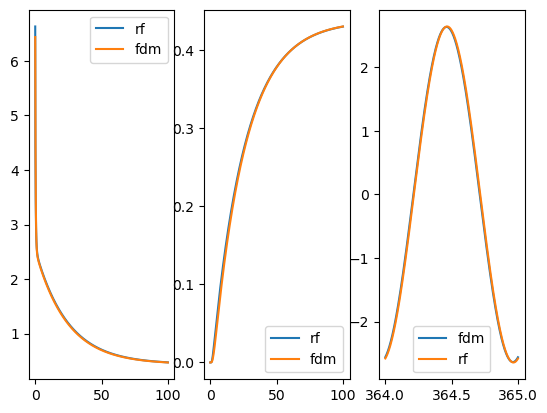

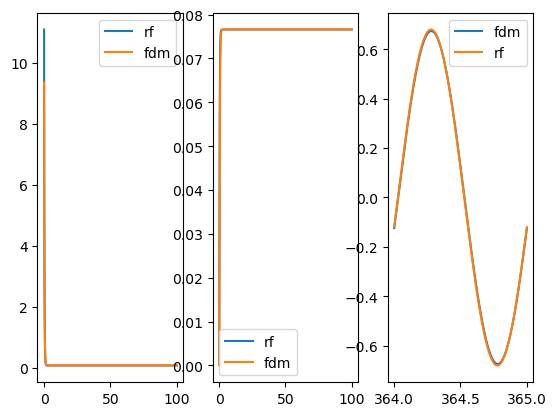

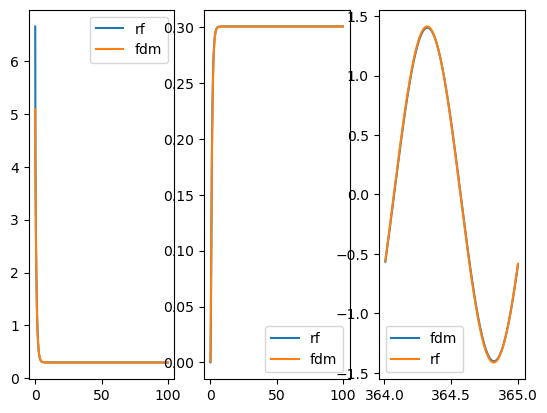

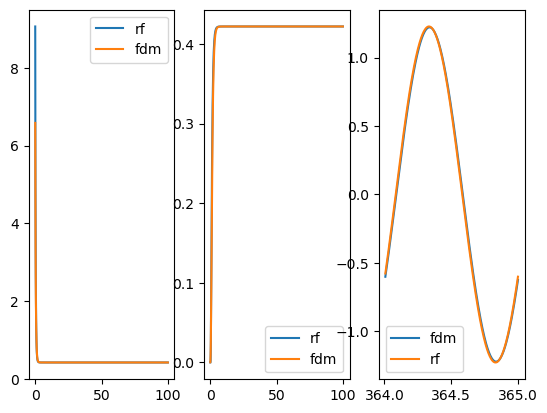

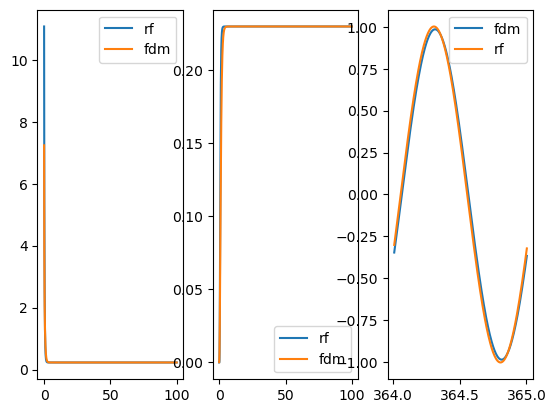

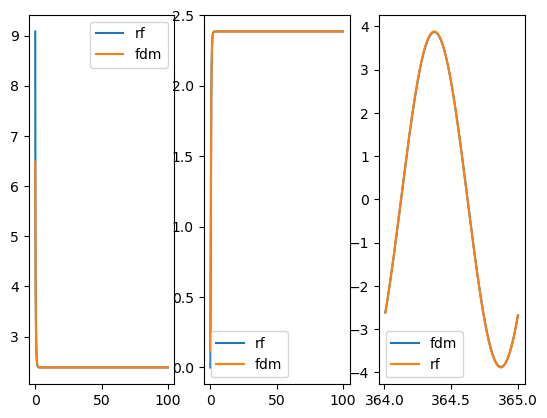

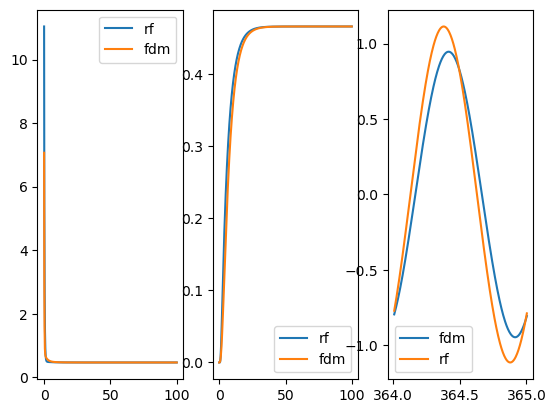

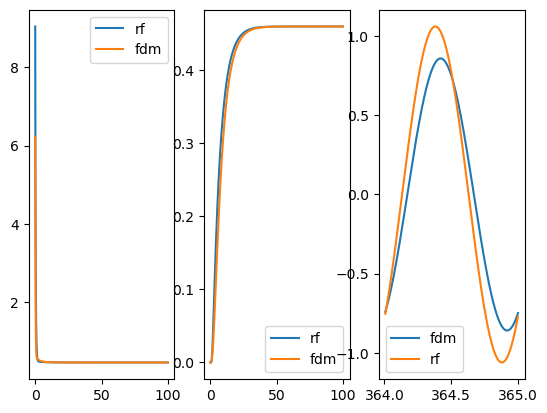

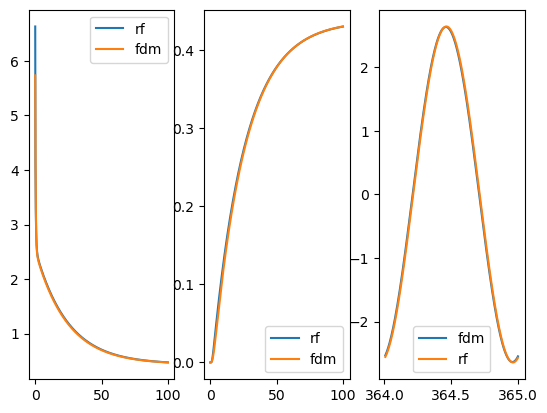

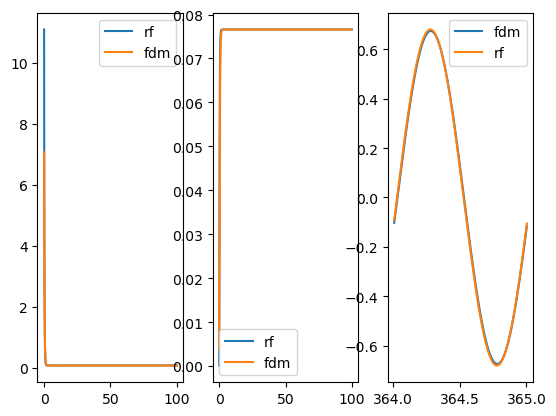

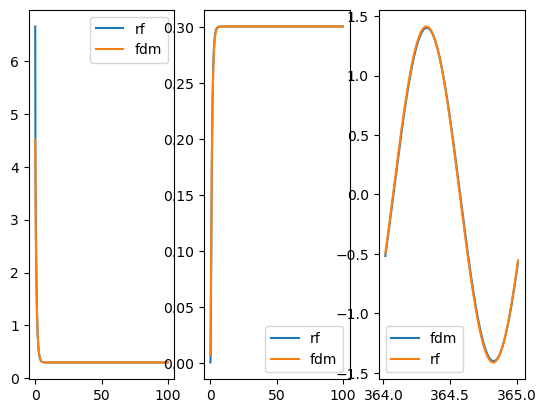

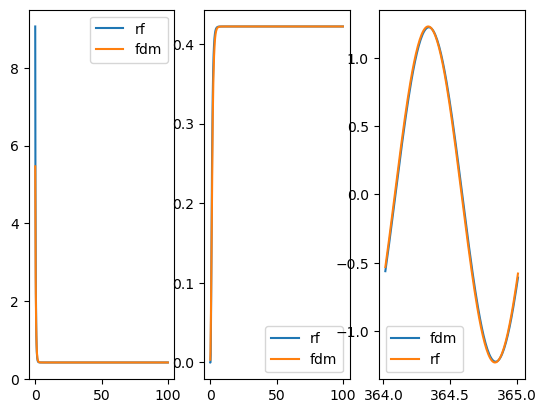

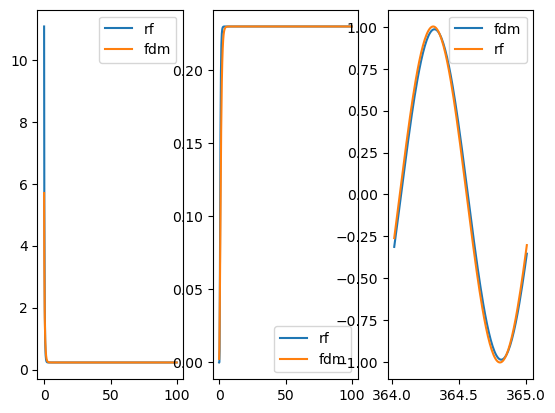

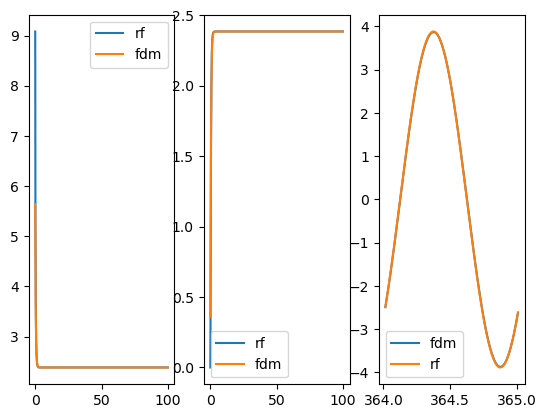

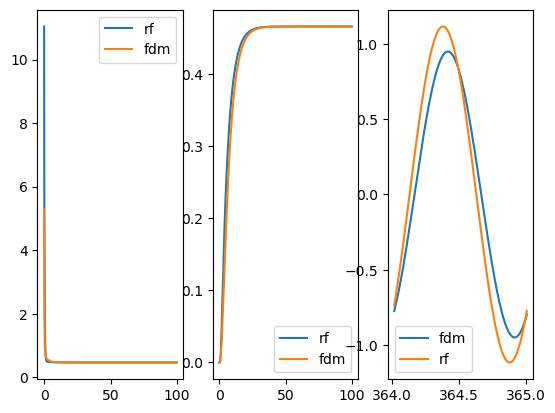

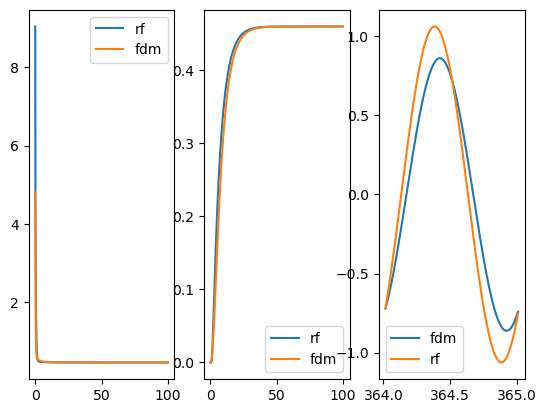

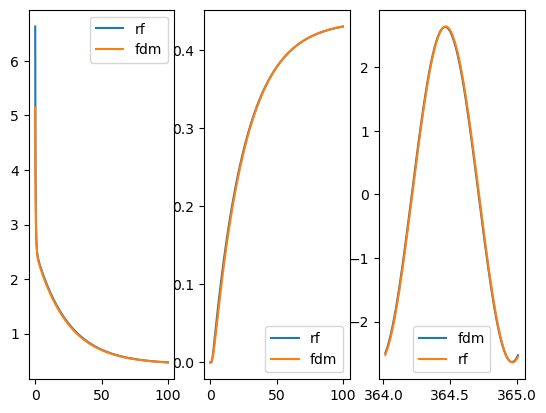

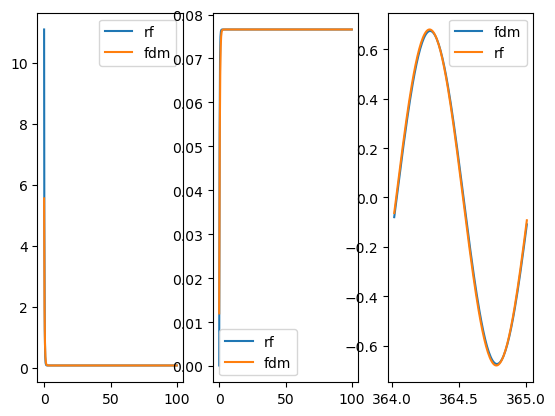

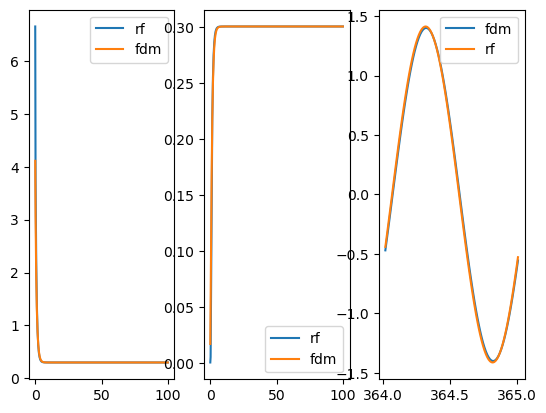

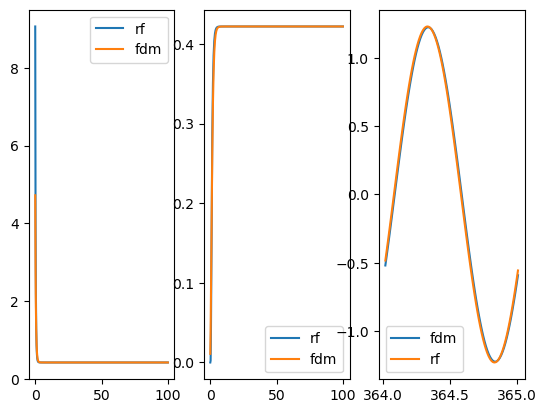

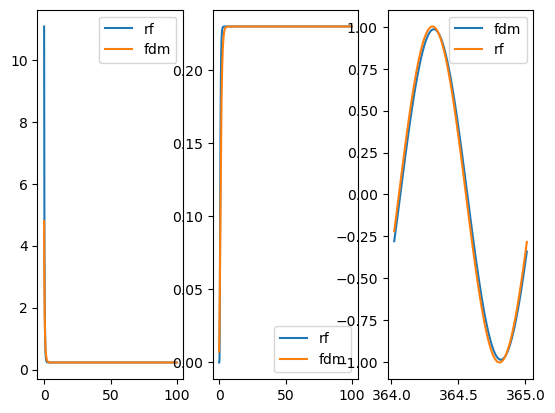

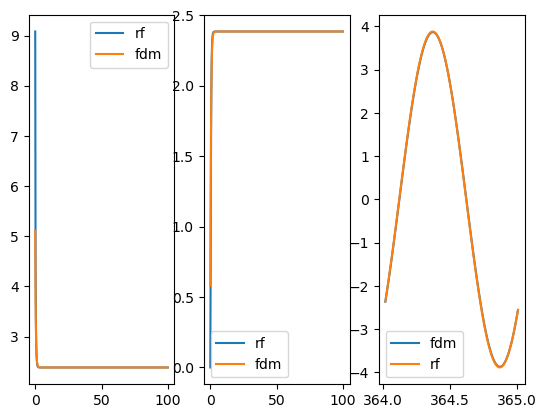

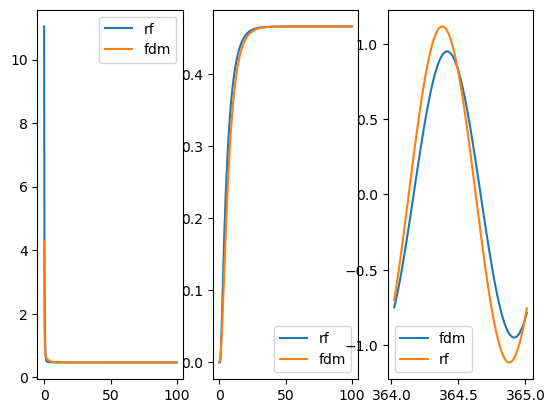

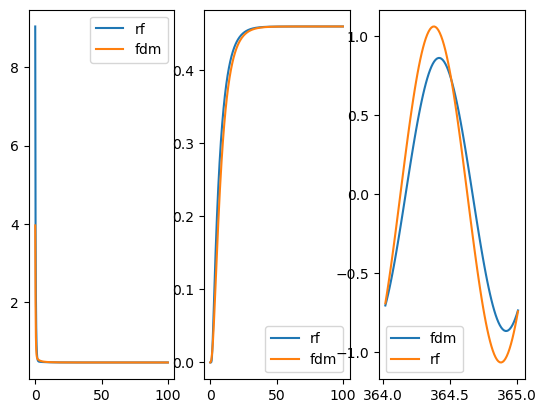

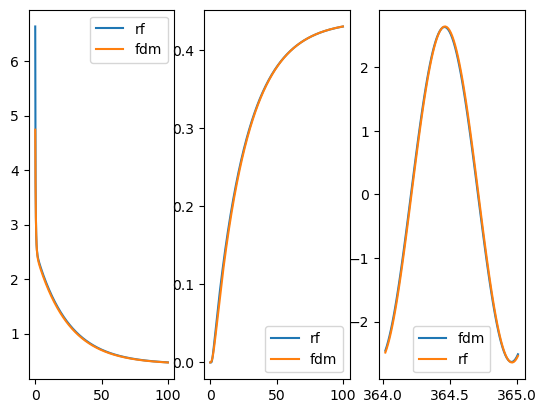

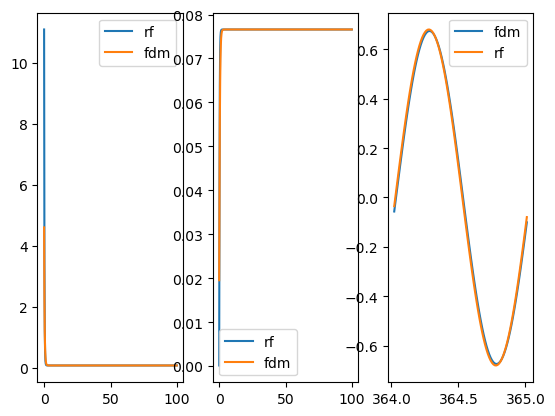

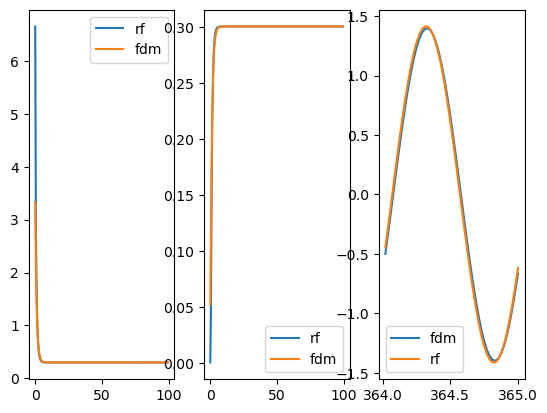

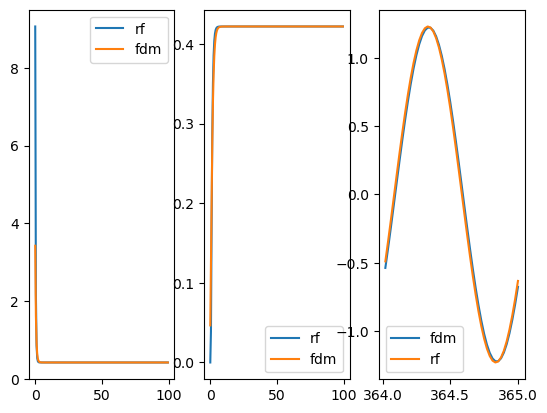

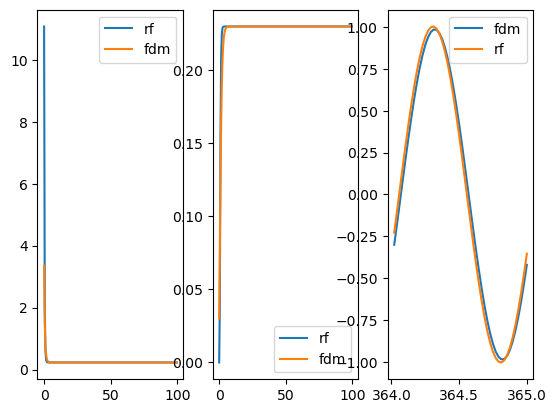

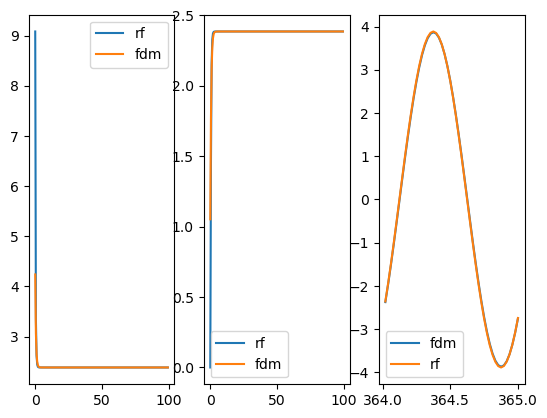

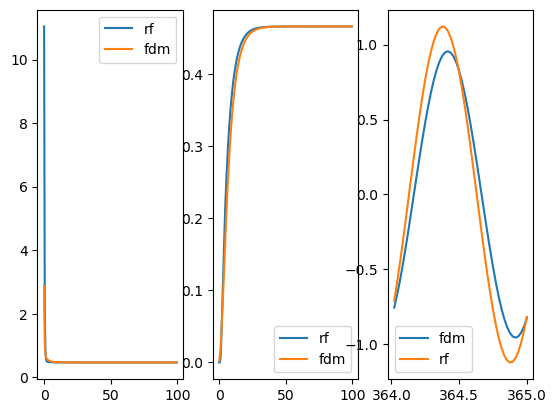

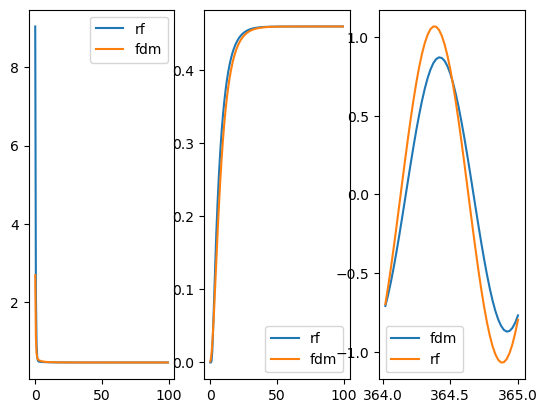

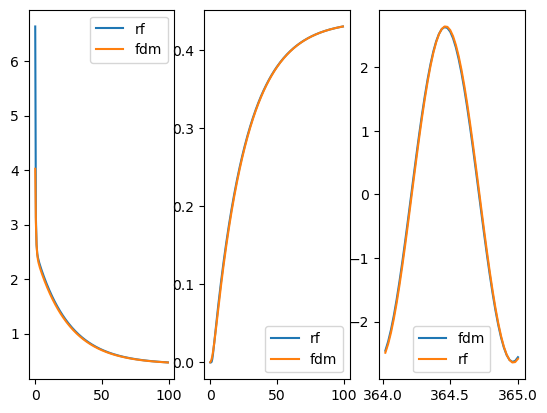

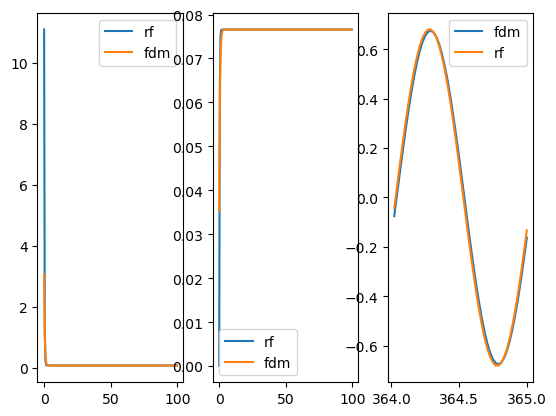

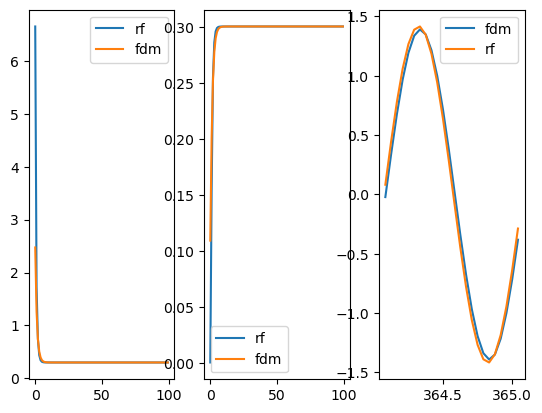

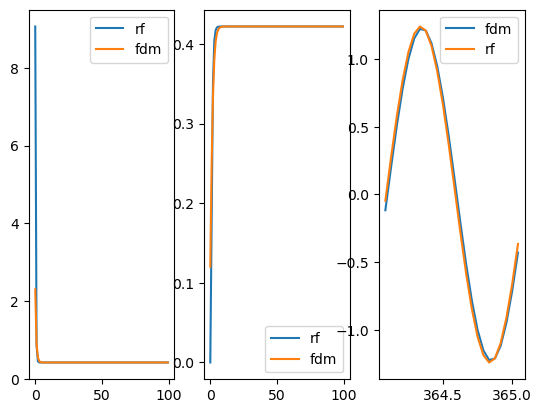

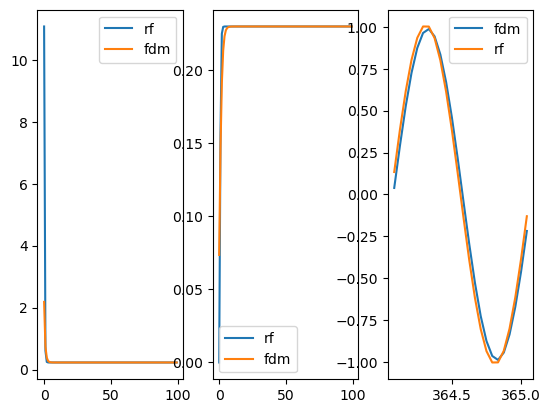

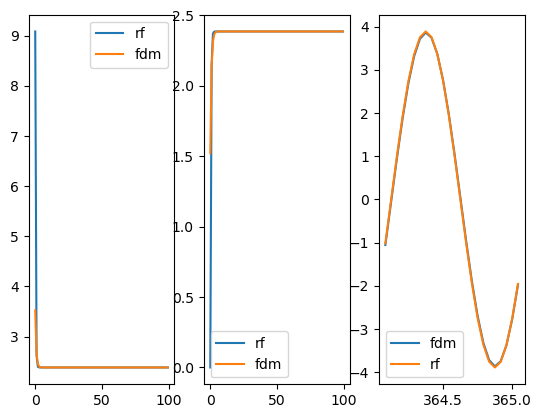

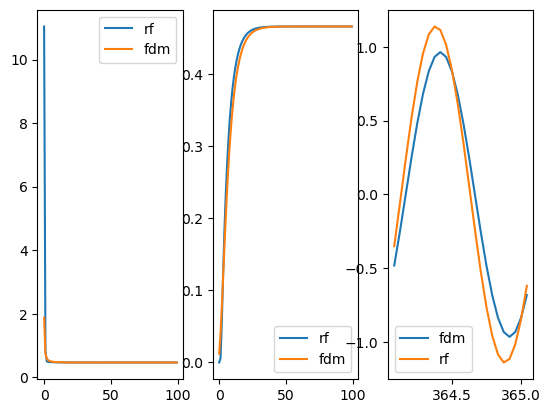

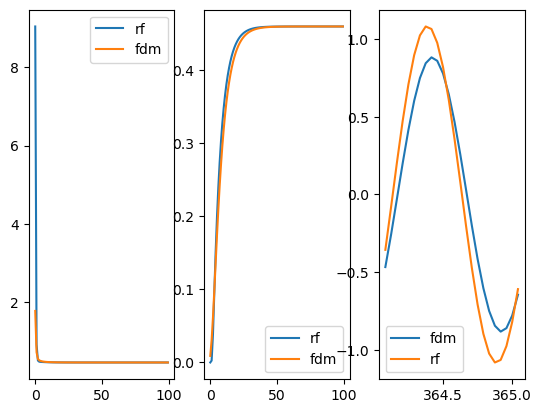

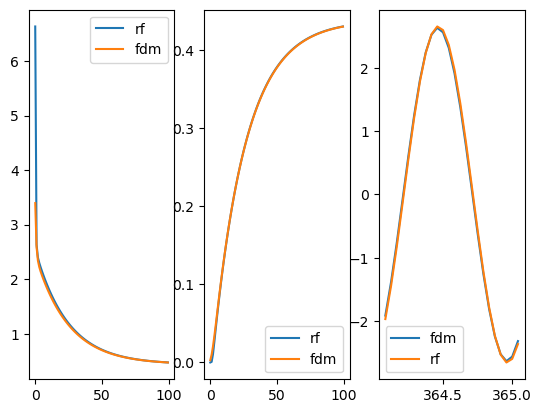

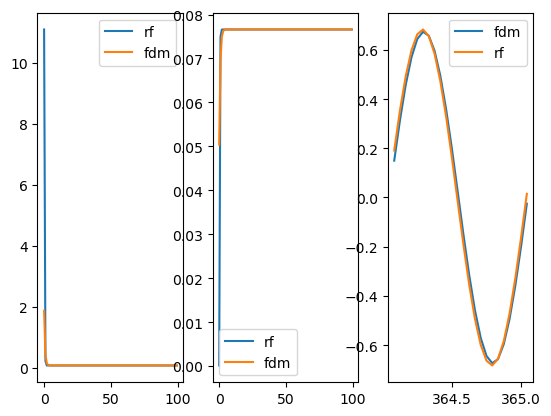

In [13]:
result = pd.DataFrame(columns=['case', 'calc_time', 'delta_t', 'n_layers', 'wall_index',
    'rmse_a', 'rmse_a_24', 'rmse_t', 'rmse_t_24', 'mae_a', 'mae_a_24', 'mae_t', 'mae_t_24', 'rmse_trif', 'mae_trif'])

i = 0
for (delta_t, n_layers, d_index) in zip(delta_t_array, n_layers_array, d_index_array):

    print(i, d_index)

    R = np.array(d['walls'][d_index]['R'])
    C = np.array(d['walls'][d_index]['C'])

    rmse_a, rmse_a_24, rmse_t, rmse_t_24, mae_a, mae_a_24, mae_t, mae_t_24, rmse_trif, mae_trif, q_a, q_t, phi_a, phi_t, q_fdm, q_rf, elapsed_time = \
        calc_surface_heat_flow(R=R, C=C, n_layers=n_layers, delta_t=delta_t)

    result.at[i, 'case'] = i
    result.at[i, 'delta_t'] = delta_t
    result.at[i, 'n_layers'] = n_layers
    result.at[i, 'wall_index'] = d_index
    result.at[i, 'rmse_a'] = rmse_a
    result.at[i, 'rmse_a_24'] = rmse_a_24
    result.at[i, 'rmse_t'] = rmse_t
    result.at[i, 'rmse_t_24'] = rmse_t_24
    result.at[i, 'mae_a'] = mae_a
    result.at[i, 'mae_a_24'] = mae_a_24
    result.at[i, 'mae_t'] = mae_t
    result.at[i, 'mae_t_24'] = mae_t_24
    result.at[i, 'rmse_trif'] = rmse_trif
    result.at[i, 'mae_trif'] = mae_trif
    result.at[i, 'calc_time'] = elapsed_time

    # 横軸
    # 差分法による単位応答の計算
    n_max = int(100 / (delta_t / 3600))
    tt = np.arange(0, delta_t / 3600.0 * (n_max), delta_t / 3600.0)
    fig, ax = plt.subplots(1, 3, squeeze=False)
    ax[0,0].plot(tt, phi_a, label='rf')
    ax[0,0].plot(tt, q_a, label='fdm')
    ax[0,0].legend()

    ax[0,1].plot(tt, phi_t, label='rf')
    ax[0,1].plot(tt, q_t, label='fdm')
    ax[0,1].legend()

    time_angle = np.arange(start=0.0, stop=365+delta_t/3600/24, step=delta_t/3600/24, dtype=float)
    n_step = int(24 * 3600 / delta_t)
    ax[0,2] = plt.plot(time_angle[-n_step:], q_fdm[-n_step:], label='fdm')
    ax[0,2] = plt.plot(time_angle[-n_step:], q_rf[-n_step:], label='rf')
    ax[0,2] = plt.legend()


    plt.savefig(os.path.join('fig/', f"case_{i}_dt_{delta_t}_layers_{n_layers}_index_{d_index}.png")) 

    i += 1

result.to_excel('result.xlsx')